In [1]:
import importlib
import volpy_func_lib as vp
import load_clean_lib
import table_lib
import vol_strat_lib as vs
import option_returns as orpy
from global_settings import *
import pandas as pd
import numpy as np
import cor_lib
import volpy_func_ticker_lib as vtp

importlib.reload(vp)
importlib.reload(load_clean_lib)
importlib.reload(table_lib)
importlib.reload(vs)
importlib.reload(orpy)
importlib.reload(vtp)
importlib.reload(cor_lib)

c:\Users\axell\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


<module 'cor_lib' from 'c:\\Users\\axell\\Desktop\\CBS\\master\\volpy\\cor_lib.py'>

### import crsp data, constituents and map constituents to crsp data and select constituents

In [87]:
importlib.reload(cor_lib)
constituents_long, daily_returns_constituents = cor_lib.get_index_constituents_and_returns("INDU")

Fil fundet: C:\Users\axell\Desktop\CBS\data\OptionMetrics\Tickers\cor metadata\daily_returns_indu.csv – loader den i stedet.


In [204]:
import pandas as pd

# Sti til din CSV-fil
path = r"C:\Users\axell\Desktop\CBS\data\OptionMetrics\Tickers\Input\ABBV\option data.csv"

# Indlæs kun header (ingen data) for at spare tid og hukommelse
df_header = pd.read_csv(path, nrows=0)

# Print kolonnenavnene
print("Kolonnenavne i filen:")
for col in df_header.columns:
    print(f" - {col}")


Kolonnenavne i filen:
 - secid
 - ticker
 - issuer
 - optionid
 - date
 - exdate
 - cp_flag
 - strike_price
 - best_bid
 - best_offer
 - impl_volatility
 - volume
 - open_interest
 - issue_type
 - exchange_d
 - ss_flag


In [209]:
import pandas as pd

# Sti til din CSV-fil
path = r"C:\Users\axell\Desktop\CBS\data\OptionMetrics\Tickers\Output\t_\AIG\od_raw.csv"

# Indlæs kun header (ingen data) for at spare tid og hukommelse
df_header = pd.read_csv(path, nrows=0)

# Print kolonnenavnene
print("Kolonnenavne i filen:")
for col in df_header.columns:
    print(f" - {col}")


Kolonnenavne i filen:
 - ticker
 - optionid
 - date
 - exdate
 - cp_flag
 - K
 - bid
 - ask
 - IV_om
 - volume
 - mid
 - n_trading_day
 - n_trading_day_exdate
 - t_days
 - t_TTM
 - c_days
 - c_TTM
 - F
 - IV
 - spread


### number of constituents with data over time 

Mindste antal aktiver på en dag: 22


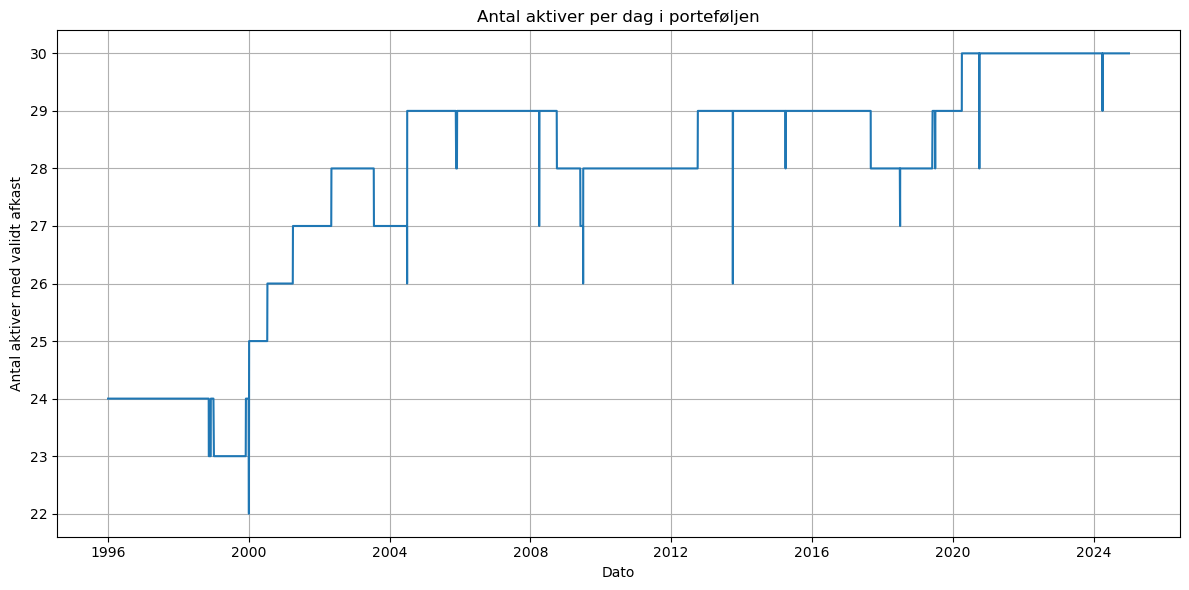

In [90]:
import matplotlib.pyplot as plt

# Tæl antal aktiver (ikke-NaN returns) per dag
assets_per_day = daily_returns_constituents.groupby("date")["return"].count()

# Udskriv mindste antal aktiver
print(f"Mindste antal aktiver på en dag: {assets_per_day.min()}")

# Plot antal aktiver over tid
plt.figure(figsize=(12,6))
plt.plot(assets_per_day.index, assets_per_day.values)
plt.xlabel("Dato")
plt.ylabel("Antal aktiver med validt afkast")
plt.title("Antal aktiver per dag i porteføljen")
plt.grid(True)
plt.tight_layout()
plt.show()


### calculate index returns

In [93]:
importlib.reload(cor_lib)
replicated_returns_daily = cor_lib.get_replicated_index_returns(daily_returns_constituents)

### get true index returns from index data (bloom) and merge to complete df

In [94]:
importlib.reload(cor_lib)
index_daily_returns_df = cor_lib.add_return_true(replicated_returns_daily, ticker = "INDU")

In [96]:
def decompose_variance_flexible_weights(
    df: pd.DataFrame,
    window: int = 30,
    average_weights: bool = True,
    rho_mean_method: str = "equal",
    min_pct: float = 0.8
) -> pd.DataFrame:
    """
    Dekomponér rullede variance- og covariance-komponenter vha. fleksible vægte.

    Parametre:
    - df: DataFrame med ["date","ticker","return","weight"]
    - window: rullevindue (dage)
    - average_weights: True -> gennemsnitsvægte, False -> vægte fra sidste dag
    - rho_mean_method: 'equal' eller 'weighted'
    - min_pct: minimum % af dage en ticker skal have retur i vinduet
    """
    df = df.sort_values(["date", "ticker"])
    dates = df["date"].drop_duplicates().sort_values().to_list()

    R = df.pivot(index="date", columns="ticker", values="return")
    W = df.pivot(index="date", columns="ticker", values="weight_lag")

    out = []
    req = int(np.ceil(window * min_pct))

    for i in range(window, len(dates)):
        dt  = dates[i]
        win = dates[i-window : i]

        r_win = R.loc[win]
        w_win = W.loc[win]

        valid = r_win.columns[r_win.notna().sum() >= req]
        if len(valid) < 2:
            continue

        r_sel = r_win[valid].dropna(axis=0)
        w_sel = w_win[valid].loc[r_sel.index]

        n_days = len(r_sel)
        if n_days < 2:
            continue

        w_ts = w_sel.mean(axis=0) if average_weights else w_sel.iloc[-1]

        sigma_t = r_sel.std(ddof=0)
        corr_t  = r_sel.corr()  # .fillna(0)

        ok = sigma_t.index[sigma_t > 0]
        if len(ok) < 2:
            continue

        wv = w_ts[ok].values
        sv = sigma_t[ok].values
        Cv = corr_t.loc[ok,ok].values

        ws = wv * sv
        var_diag    = np.sum((wv**2) * (sv**2))
        var_offdiag = np.sum(np.outer(ws, ws) * Cv) - np.sum(ws**2)
        var_tot     = var_diag + var_offdiag

        if rho_mean_method == "equal":
            mask     = ~np.eye(len(ok), dtype=bool)
            rho_mean = Cv[mask].mean()
        else:
            rho_sum  = np.sum(np.outer(wv, wv) * Cv) - np.sum(wv**2)
            rho_mean = rho_sum / (1 - np.sum(wv**2))

        out.append({
            "date":                     dt,
            "vol_variance_component":   np.sqrt(var_diag    * 252),
            "vol_covariance_component": np.sqrt(var_offdiag * 252),
            "vol_total_reconstructed":  np.sqrt(var_tot     * 252),
            "rho_mean":                 rho_mean,
            "n_assets_used":            len(ok),
            "n_days_used":              n_days
        })

    return pd.DataFrame(out)


def add_all_variance_components(
    index_df: pd.DataFrame,
    constituents_df: pd.DataFrame,
    window: int = 30,
    average_weights: bool = True,
    rho_mean_method: str = "equal",
    min_pct: float = 0.8
) -> pd.DataFrame:
    """
    Tilføj alle volatility‐kolonner til index_df:
      - vol_rolling_true
      - vol_rolling_replicated
      - vol_variance_component
      - vol_covariance_component
      - vol_total_reconstructed
      - rho_mean
      - n_assets_used
      - n_days_used
    """
    idx = index_df.copy()
    idx["date"] = pd.to_datetime(idx["date"])
    idx["vol_rolling_true"]       = idx["return_true"].rolling(window).std(ddof=0)       * np.sqrt(252)
    idx["vol_rolling_replicated"] = idx["return_replicated"].rolling(window).std(ddof=0) * np.sqrt(252)

    var_corr_df = decompose_variance_flexible_weights(
        constituents_df,
        window=window,
        average_weights=average_weights,
        rho_mean_method=rho_mean_method,
        min_pct=min_pct
    )
    var_corr_df["date"] = pd.to_datetime(var_corr_df["date"])

    return idx.merge(var_corr_df, on="date", how="left")


# Eksempel på kørsel:
index_df = add_all_variance_components(
    index_daily_returns_df,
    daily_returns_constituents,
    window=21*3,
    average_weights=False,
    rho_mean_method="equal", # weighted
    min_pct=0.9
)

### added sigma mean

In [163]:
import pandas as pd
import numpy as np

def decompose_variance_flexible_weights(
    df: pd.DataFrame,
    window: int = 30,
    average_weights: bool = True,
    mean_method: str = "equal",  # 'equal' eller 'weighted'
    min_pct: float = 0.8
) -> pd.DataFrame:
    """
    Dekomponér rullede variance- og covariance-komponenter vha. fleksible vægte.

    Parametre:
    - df: DataFrame med ["date","ticker","return","weight_lag"]
    - window: rullevindue (dage)
    - average_weights: True -> gennemsnitsvægte, False -> vægte fra sidste dag
    - mean_method: 'equal' eller 'weighted' for beregning af både sigma_mean og rho_mean
    - min_pct: minimum % af dage en ticker skal have retur i vinduet

    Returnerer for hver dato:
      - vol_variance_component
      - vol_covariance_component
      - vol_total_reconstructed
      - rho_mean
      - sigma_mean
      - n_assets_used
      - n_days_used
    """
    df = df.sort_values(["date", "ticker"])
    dates = df["date"].drop_duplicates().sort_values().to_list()

    R = df.pivot(index="date", columns="ticker", values="return")
    W = df.pivot(index="date", columns="ticker", values="weight_lag")

    out = []
    req = int(np.ceil(window * min_pct))

    for i in range(window, len(dates)):
        dt  = dates[i]
        win = dates[i-window : i]

        r_win = R.loc[win]
        w_win = W.loc[win]

        # 1) filtrér tickers med utilstrækkelig data
        valid = r_win.columns[r_win.notna().sum() >= req]
        if len(valid) < 2:
            continue

        r_sel = r_win[valid].dropna(axis=0)
        w_sel = w_win[valid].loc[r_sel.index]

        n_days = len(r_sel)
        if n_days < 2:
            continue

        # 2) vægte
        w_ts = w_sel.mean(axis=0) if average_weights else w_sel.iloc[-1]

        # 3) beregn sigma og corr
        sigma_t = r_sel.std(ddof=0)
        corr_t  = r_sel.corr()

        # 4) trim til tickers med positiv sigma
        ok = sigma_t.index[sigma_t > 0]
        if len(ok) < 2:
            continue

        wv = w_ts[ok].values
        sv = sigma_t[ok].values
        Cv = corr_t.loc[ok,ok].values

        # 5) variance‐komponenter
        ws = wv * sv
        var_diag    = np.sum((wv**2) * (sv**2))
        var_offdiag = np.sum(np.outer(ws, ws) * Cv) - np.sum(ws**2)
        var_tot     = var_diag + var_offdiag

        # 6) sigma_mean
        if mean_method == "equal":
            sigma_mean = sv.mean()
        else:  # weighted
            # normaliser vægte
            w_norm = wv / wv.sum()
            sigma_mean = np.dot(w_norm, sv)

        # 7) rho_mean
        mask = ~np.eye(len(ok), dtype=bool)
        if mean_method == "equal":
            rho_mean = Cv[mask].mean()
        else:
            # vægtet gennemsnit af off‐diag elementer
            # lav matrix af wv[i]*wv[j]
            W2 = np.outer(wv, wv)
            rho_sum = np.sum(W2[mask] * Cv[mask])
            rho_mean = rho_sum / np.sum(W2[mask])

        out.append({
            "date":                     dt,
            "vol_variance_component":   np.sqrt(var_diag    * 252),
            "vol_covariance_component": np.sqrt(var_offdiag * 252),
            "vol_total_reconstructed":  np.sqrt(var_tot     * 252),
            "rho_mean":                 rho_mean,
            "sigma_mean":               sigma_mean,
            "n_assets_used":            len(ok),
            "n_days_used":              n_days
        })

    return pd.DataFrame(out)


def add_all_variance_components(
    index_df: pd.DataFrame,
    constituents_df: pd.DataFrame,
    window: int = 30,
    average_weights: bool = True,
    mean_method: str = "equal",
    min_pct: float = 0.8
) -> pd.DataFrame:
    """
    Tilføj alle volatility‐kolonner til index_df:
      - vol_rolling_true
      - vol_rolling_replicated
      - vol_variance_component
      - vol_covariance_component
      - vol_total_reconstructed
      - rho_mean
      - sigma_mean
      - n_assets_used
      - n_days_used
    """
    idx = index_df.copy()
    idx["date"] = pd.to_datetime(idx["date"])
    idx["vol_rolling_true"]       = (
        idx["return_true"]
        .rolling(window)
        .std(ddof=0)
        * np.sqrt(252)
    )
    idx["vol_rolling_replicated"] = (
        idx["return_replicated"]
        .rolling(window)
        .std(ddof=0)
        * np.sqrt(252)
    )

    var_corr_df = decompose_variance_flexible_weights(
        constituents_df,
        window=window,
        average_weights=average_weights,
        mean_method=mean_method,
        min_pct=min_pct
    )
    var_corr_df["date"] = pd.to_datetime(var_corr_df["date"])

    return idx.merge(var_corr_df, on="date", how="left")


# Eksempel på kørsel:
index_df = add_all_variance_components(
    index_daily_returns_df,
    daily_returns_constituents,
    window=21*3,
    average_weights=False,
    mean_method="weighted",   # 'equal' eller 'weighted'
    min_pct=0.9
)


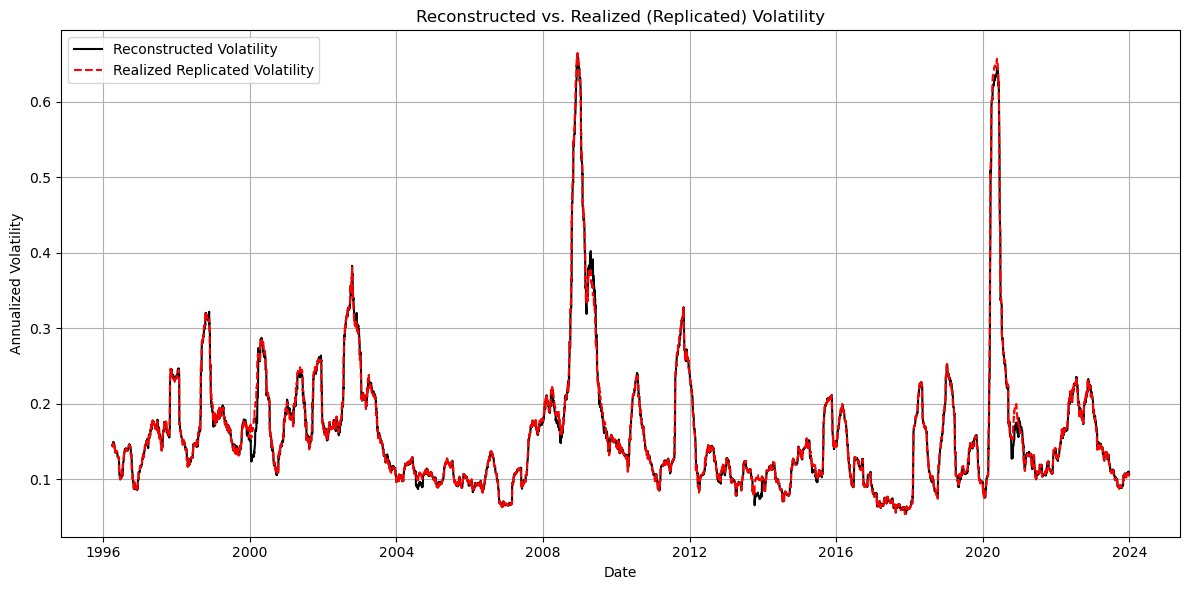

In [164]:
import matplotlib.pyplot as plt

def plot_reconstructed_vs_replicated_vol(df, start_date=None, end_date=None):
    # Filtrér datoer hvis angivet
    plot_df = df.copy()
    if start_date:
        plot_df = plot_df[plot_df["date"] >= pd.to_datetime(start_date)]
    if end_date:
        plot_df = plot_df[plot_df["date"] <= pd.to_datetime(end_date)]

    # Plot
    plt.figure(figsize=(12, 6))
    plt.plot(plot_df["date"], plot_df["vol_total_reconstructed"], label="Reconstructed Volatility", color="black")
    plt.plot(plot_df["date"], plot_df["vol_rolling_replicated"], label="Realized Replicated Volatility", color="red", linestyle="--")
    
    plt.title("Reconstructed vs. Realized (Replicated) Volatility")
    plt.xlabel("Date")
    plt.ylabel("Annualized Volatility")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_reconstructed_vs_replicated_vol(index_df, start_date="1996-01-01", end_date="2023-12-31")


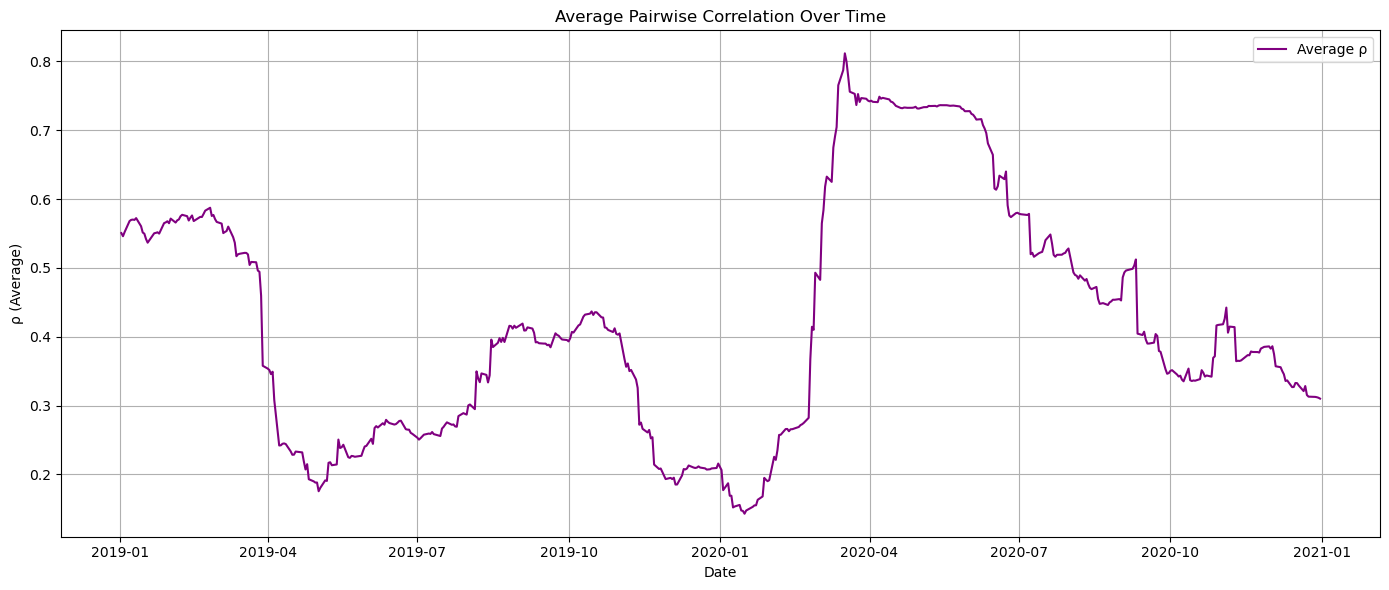

In [165]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_rho_mean(df, start_date=None, end_date=None):
    """
    Plots the rolling average pairwise correlation (rho_mean) over time.
    
    Parametre:
    - df         : DataFrame med mindst kolonnerne ['date','rho_mean']
    - start_date : (valgfri) streng "YYYY-MM-DD" for plotstart
    - end_date   : (valgfri) streng "YYYY-MM-DD" for plotslut
    """
    plot_df = df.copy()
    plot_df["date"] = pd.to_datetime(plot_df["date"])
    
    if start_date:
        plot_df = plot_df[plot_df["date"] >= pd.to_datetime(start_date)]
    if end_date:
        plot_df = plot_df[plot_df["date"] <= pd.to_datetime(end_date)]
    
    plt.figure(figsize=(14, 6))
    plt.plot(plot_df["date"], plot_df["rho_mean"], color="purple", label="Average ρ")
    plt.title("Average Pairwise Correlation Over Time")
    plt.xlabel("Date")
    plt.ylabel("ρ (Average)")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Eksempel på kald:
plot_rho_mean(index_df, start_date="2019-01-01", end_date="2021-01-01")


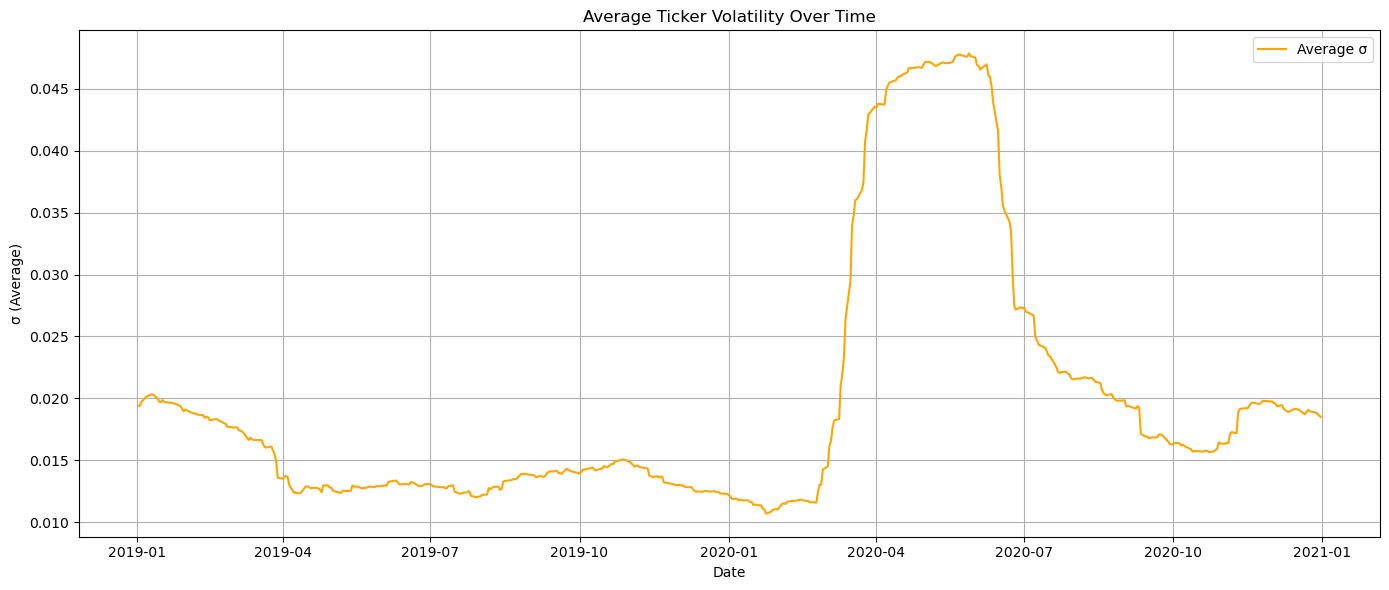

In [166]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_sigma_mean(df, start_date=None, end_date=None):
    """
    Plots the rolling average ticker volatility (sigma_mean) over time.
    
    Parametre:
    - df         : DataFrame med mindst kolonnerne ['date','sigma_mean']
    - start_date : (valgfri) streng "YYYY-MM-DD" for plotstart
    - end_date   : (valgfri) streng "YYYY-MM-DD" for plotslut
    """
    plot_df = df.copy()
    plot_df["date"] = pd.to_datetime(plot_df["date"])
    
    if start_date:
        plot_df = plot_df[plot_df["date"] >= pd.to_datetime(start_date)]
    if end_date:
        plot_df = plot_df[plot_df["date"] <= pd.to_datetime(end_date)]
    
    plt.figure(figsize=(14, 6))
    plt.plot(plot_df["date"], plot_df["sigma_mean"], color="orange", label="Average σ")
    plt.title("Average Ticker Volatility Over Time")
    plt.xlabel("Date")
    plt.ylabel("σ (Average)")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Eksempel på kald:
plot_sigma_mean(index_df, start_date="2019-01-01", end_date="2021-01-01")


### decomp v1 with fixed counterpart

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def decompose_total_variance_fixed_elements(
    df: pd.DataFrame,
    window: int = 30,
    fix_to_constant: bool = False,
    min_pct: float = 0.8
) -> pd.DataFrame:
    """
    Dekomponér den samlede porteføljevariance og beregn:
      - vol_total_reconstructed
      - vol_total_fixed_sigma
      - vol_total_fixed_rho
      - n_assets_used
      - n_days_used

    Parametre:
    - df: DataFrame med ["date","ticker","return","weight"]
    - window: rullevindue (antal dage)
    - fix_to_constant: Hvis True, bruger konstante gennemsnits‐σ og ρ over hele perioden
    - min_pct: minimum % af dage en ticker skal have retur i vinduet
    """
    df = df.sort_values(["date", "ticker"])
    dates = df["date"].drop_duplicates().sort_values().to_list()

    R = df.pivot(index="date", columns="ticker", values="return")
    W = df.pivot(index="date", columns="ticker", values="weight_lag")

    fixed_sigma = R.std(ddof=0)
    fixed_corr  = R.corr()

    if fix_to_constant:
        sigma_bar = fixed_sigma.mean()
        rho_bar   = fixed_corr.stack().mean()

    out = []
    req = int(np.ceil(window * min_pct))

    for i in range(window, len(dates)):
        dt  = dates[i]
        win = dates[i-window : i]

        r_win = R.loc[win]
        w_win = W.loc[win]

        # a) filtrér tickers på minimumsdækning
        valid = r_win.columns[r_win.notna().sum() >= req]
        if len(valid) < 2:
            continue

        r_sel = r_win[valid].dropna(axis=0)
        w_sel = w_win[valid].loc[r_sel.index]

        n_days = len(r_sel)
        if n_days < 2:
            continue

        # b) vægte fra sidste dag
        w_t = w_sel.iloc[-1]

        # c) beregn population std & corr på de rensede data
        sigma_t = r_sel.std(ddof=0)
        corr_t  = r_sel.corr()   # .fillna(0)

        ok = sigma_t.index[sigma_t > 0]
        if len(ok) < 2:
            continue

        wv  = w_t[ok].values
        sv  = sigma_t[ok].values
        Cv  = corr_t.loc[ok,ok].values
        fsv = fixed_sigma[ok].values
        fcv = fixed_corr.loc[ok,ok].values

        if fix_to_constant:
            fsv[:] = sigma_bar
            fcv[:] = rho_bar
            np.fill_diagonal(fcv, 1.0)

        cov_t    = np.outer(sv, sv) * Cv
        cov_fsig = np.outer(fsv, fsv) * Cv
        cov_frho = np.outer(sv, sv) * fcv

        var_act = wv @ (cov_t    @ wv)
        var_sig = wv @ (cov_fsig @ wv)
        var_rho = wv @ (cov_frho @ wv)

        out.append({
            "date":                   dt,
            "vol_total_reconstructed": np.sqrt(max(0, var_act * 252)),
            "vol_total_fixed_sigma":   np.sqrt(max(0, var_sig * 252)),
            "vol_total_fixed_rho":     np.sqrt(max(0, var_rho * 252)),
            "n_assets_used":           len(ok),
            "n_days_used":             n_days
        })

    return pd.DataFrame(out)

decomp_df = decompose_total_variance_fixed_elements(
    daily_returns_constituents,
    window=21*3,
    fix_to_constant=True,
    min_pct=0.9
)




### decomp v2 (rquiring a min observations to be in fixed cor or sigma) with fixed cvounterpart

In [123]:
import pandas as pd
import numpy as np

def decompose_total_variance_fixed_elements_v2(
    df: pd.DataFrame,
    window: int = 30,
    fix_to_constant: bool = False,
    min_pct: float = 0.8,
    min_obs: int = 20
) -> pd.DataFrame:
    """
    Dekomponér den samlede porteføljevariance og beregn:
      - vol_total_reconstructed
      - vol_total_fixed_sigma
      - vol_total_fixed_rho
      - n_assets_used
      - n_days_used

    Parametre:
    - df: DataFrame med ["date","ticker","return","weight_lag"]
    - window: rullevindue (antal dage)
    - fix_to_constant: Hvis True, bruger konstante gennemsnits‐σ og ρ over hele perioden
    - min_pct: minimum % af dage en ticker skal have retur i vinduet
    - min_obs: minimum antal fælles dage for at en parvis ρ/σ² tæller med i fixed-værdier
    """
    # 1) Forbered
    df = df.sort_values(["date", "ticker"])
    dates = df["date"].drop_duplicates().sort_values().to_list()

    # 2) Pivot return & vægte
    R = df.pivot(index="date", columns="ticker", values="return")
    W = df.pivot(index="date", columns="ticker", values="weight_lag")

    # 3) Build mask‐matrix over fælles dage
    present = R.notna().astype(int)
    counts  = present.T.dot(present)    # counts[i,j] = antal dage hvor både i og j er obs

    # 4) Rå kovarians og korrelation (pairwise)
    raw_cov  = R.cov()
    raw_corr = R.corr()

    # 5) Maskér alt med for få fælles dage
    fixed_cov  = raw_cov.where(counts >= min_obs)
    fixed_corr = raw_corr.where(counts >= min_obs)

    # 6) Træk fixed_sigma ud fra diagonalen af fixed_cov
    fixed_sigma = pd.Series(
        np.sqrt(np.diag(fixed_cov.values)),
        index=fixed_cov.index
    )

    # 7) Hvis vi vil “fixe” konstant over hele sample
    if fix_to_constant:
        sigma_bar = fixed_sigma.mean()
        rho_bar   = fixed_corr.stack().mean()

    out = []
    req = int(np.ceil(window * min_pct))

    # 8) Loop over rullevinduer
    for i in range(window, len(dates)):
        dt  = dates[i]
        win = dates[i-window : i]

        r_win = R.loc[win]
        w_win = W.loc[win]

        # a) filtrér tickers med < min_pct coverage
        valid = r_win.columns[r_win.notna().sum() >= req]
        if len(valid) < 2:
            continue

        # b) drop dage med én NaN i de valgte tickers
        r_sel = r_win[valid].dropna(axis=0)
        w_sel = w_win[valid].loc[r_sel.index]
        n_days = len(r_sel)
        if n_days < 2:
            continue

        # c) vægte fra sidste dag
        w_t = w_sel.iloc[-1]

        # d) population sigma & corr på renset data
        sigma_t = r_sel.std(ddof=0)
        corr_t  = r_sel.corr()

        # e) trim til tickers med positiv sigma
        ok = sigma_t.index[sigma_t > 0]
        if len(ok) < 2:
            continue

        wv  = w_t[ok].values
        sv  = sigma_t[ok].values
        Cv  = corr_t.loc[ok, ok].values
        fsv = fixed_sigma[ok].values
        fcv = fixed_corr.loc[ok, ok].values

        # f) hvis konstant-fix, overskriv med globale gennemsnit
        if fix_to_constant:
            fsv[:] = sigma_bar
            fcv[:] = rho_bar
            np.fill_diagonal(fcv, 1.0)

        # g) bygg covariance‐matricer
        cov_t    = np.outer(sv, sv) * Cv
        cov_fsig = np.outer(fsv, fsv) * Cv
        cov_frho = np.outer(sv, sv) * fcv

        # h) porteføljevarians
        var_act = wv @ (cov_t    @ wv)
        var_sig = wv @ (cov_fsig @ wv)
        var_rho = wv @ (cov_frho @ wv)

        out.append({
            "date":                    dt,
            "vol_total_reconstructed": np.sqrt(max(0, var_act * 252)),
            "vol_total_fixed_sigma":   np.sqrt(max(0, var_sig * 252)),
            "vol_total_fixed_rho":     np.sqrt(max(0, var_rho * 252)),
            "n_assets_used":           len(ok),
            "n_days_used":             n_days
        })

    return pd.DataFrame(out)


decomp_df = decompose_total_variance_fixed_elements_v2(
    daily_returns_constituents,
    window=21*3,          # 3-måneders rul
    fix_to_constant=True, # brug konstante global σ & ρ
    min_pct=0.9,          # 90% coverage pr. ticker
    min_obs=20            # mindst 20 fælles dage for at ρ/σ tæller med
)


### v3 with only off diagonal

In [157]:
import pandas as pd
import numpy as np

def decompose_total_variance_fixed_elements_v3(
    df: pd.DataFrame,
    window: int = 30,
    fix_to_constant: bool = False,
    min_pct: float = 0.8,
    min_obs: int = 20
) -> pd.DataFrame:
    """
    Version 3: Samme som v2, men TOTAL_VARIANS (= vol_total_reconstructed)
    og de faste komponenter beregnes *kun på off‐diagonal* (altså uden idiosynkratisk/diagonal‐risk).

    Parametre:
    - df: DataFrame med ["date","ticker","return","weight_lag"]
    - window: rullevindue i dage
    - fix_to_constant: True -> brug konstante σ̄ og ρ̄ ved off‐diag‐beregningen
    - min_pct: min % af dage en ticker skal have data i vinduet
    - min_obs: min antal fælles dage for at en par‐vis ρ/σ tæller med i fixed‐værdier
    """
    df = df.sort_values(["date", "ticker"])
    dates = df["date"].drop_duplicates().sort_values().to_list()

    # Pivotér returns og laggede vægte
    R = df.pivot(index="date", columns="ticker", values="return")
    W = df.pivot(index="date", columns="ticker", values="weight_lag")

    # Build matrix over fælles observationer
    present = R.notna().astype(int)
    counts  = present.T.dot(present)

    # Rå kovarianser/korrelationer
    raw_cov  = R.cov()
    raw_corr = R.corr()

    # Maskér fixed‐parametre ved min_obs
    fixed_cov  = raw_cov.where(counts >= min_obs)
    fixed_corr = raw_corr.where(counts >= min_obs)

    # Udtræk faste σ fra diagonalen af fixed_cov
    fixed_sigma = pd.Series(
        np.sqrt(np.diag(fixed_cov.values)),
        index=fixed_cov.index
    )

    # Globale gennemsnit, hvis vi fikser konstant
    if fix_to_constant:
        sigma_bar = fixed_sigma.mean()
        rho_bar   = fixed_corr.stack().mean()

    out = []
    req = int(np.ceil(window * min_pct))

    for i in range(window, len(dates)):
        dt  = dates[i]
        win = dates[i-window : i]

        r_win = R.loc[win]
        w_win = W.loc[win]

        # 1) filtrér tickers med for få dage
        valid = r_win.columns[r_win.notna().sum() >= req]
        if len(valid) < 2:
            continue

        # 2) drop days with any NaN in these tickers
        r_sel = r_win[valid].dropna(axis=0)
        w_sel = w_win[valid].loc[r_sel.index]
        n_days = len(r_sel)
        if n_days < 2:
            continue

        # 3) vægte fra sidste dag
        w_t = w_sel.iloc[-1]

        # 4) population σ og ρ på renset data
        sigma_t = r_sel.std(ddof=0)
        corr_t  = r_sel.corr()

        # Tickere med positiv σ
        ok = sigma_t.index[sigma_t > 0]
        if len(ok) < 2:
            continue

        # Arrays
        wv = w_t[ok].values
        sv = sigma_t[ok].values
        Cv = corr_t.loc[ok, ok].values
        fsv = fixed_sigma[ok].values
        fcv = fixed_corr.loc[ok, ok].values

        if fix_to_constant:
            fsv[:] = sigma_bar
            fcv[:] = rho_bar
            np.fill_diagonal(fcv, 1.0)

        # Byg covariance matricer
        cov_t    = np.outer(sv,    sv)    * Cv
        cov_fsig = np.outer(fsv,   fsv)   * Cv
        cov_frho = np.outer(sv,    sv)    * fcv

        # Beregn bidrag
        # diag‐bidrag, som vi nu vil ekskludere:
        var_diag = np.sum((wv**2) * (sv**2))

        # off‐diag‐bidrag:
        var_offdiag      = np.dot(wv, cov_t    @ wv) - var_diag
        var_offdiag_sig  = np.dot(wv, cov_fsig @ wv) - np.sum((wv**2) * (fsv**2))
        var_offdiag_rho  = np.dot(wv, cov_frho @ wv) - var_diag  # diag for cov_frho = sv^2

        out.append({
            "date":                    dt,
            # kun off‐diag bidrag annualiseret:
            "vol_total_reconstructed": np.sqrt(max(0, var_offdiag     * 252)),
            "vol_total_fixed_sigma":   np.sqrt(max(0, var_offdiag_sig * 252)),
            "vol_total_fixed_rho":     np.sqrt(max(0, var_offdiag_rho * 252)),
            "n_assets_used":           len(ok),
            "n_days_used":             n_days
        })

    return pd.DataFrame(out)


# Eksempel på kørsel:
decomp_df = decompose_total_variance_fixed_elements_v3(
    daily_returns_constituents,
    window=21*3,
    fix_to_constant=True,
    min_pct=0.9,
    min_obs=20
)


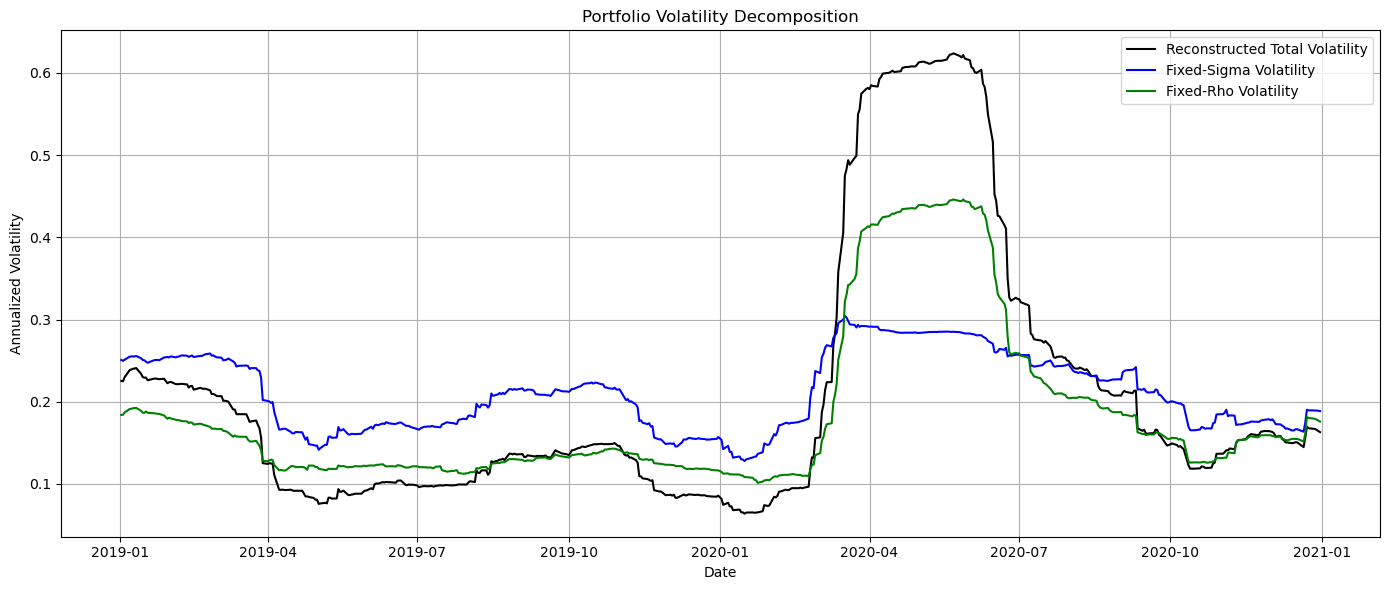

In [167]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_volatility_decomposition(
    df: pd.DataFrame,
    start_date: str = None,
    end_date:   str = None
):
    plot_df = df.copy()
    plot_df['date'] = pd.to_datetime(plot_df['date'])

    if start_date:
        plot_df = plot_df[plot_df['date'] >= pd.to_datetime(start_date)]
    if end_date:
        plot_df = plot_df[plot_df['date'] <= pd.to_datetime(end_date)]

    plt.figure(figsize=(14, 6))
    plt.plot(
        plot_df['date'],
        plot_df['vol_total_reconstructed'],
        label='Reconstructed Total Volatility',
        color='black'
    )
    plt.plot(
        plot_df['date'],
        plot_df['vol_total_fixed_sigma'],
        label='Fixed‐Sigma Volatility',
        color='blue'
    )
    plt.plot(
        plot_df['date'],
        plot_df['vol_total_fixed_rho'],
        label='Fixed‐Rho Volatility',
        color='green'
    )

    plt.title('Portfolio Volatility Decomposition')
    plt.xlabel('Date')
    plt.ylabel('Annualized Volatility')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Example usage:
plot_volatility_decomposition(decomp_df, start_date="2019-01-01", end_date="2021-01-01")


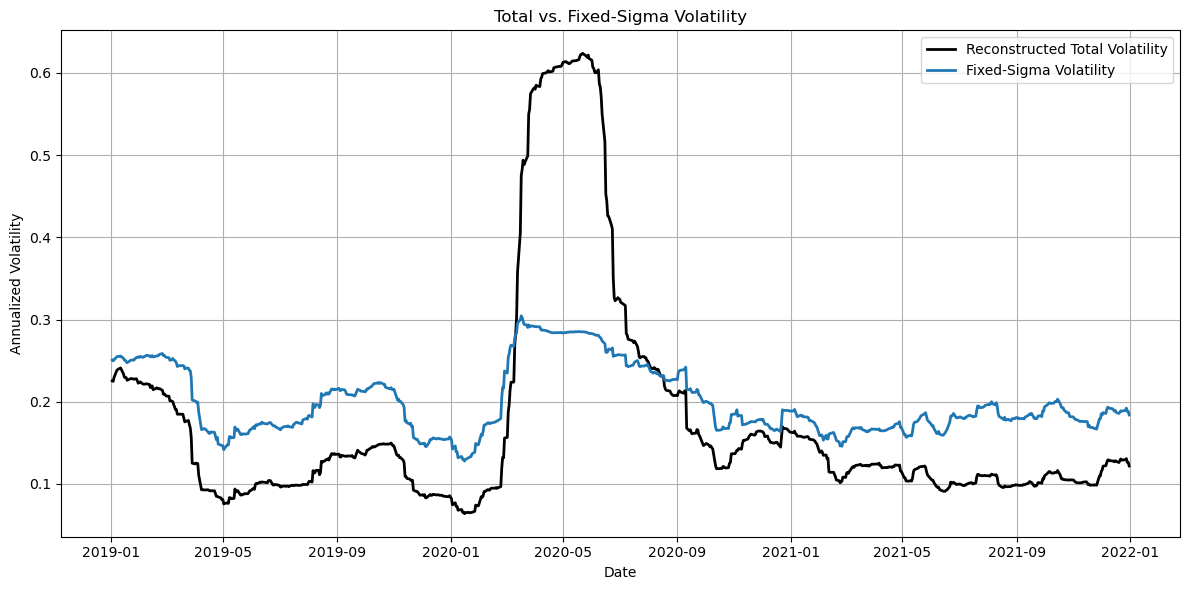

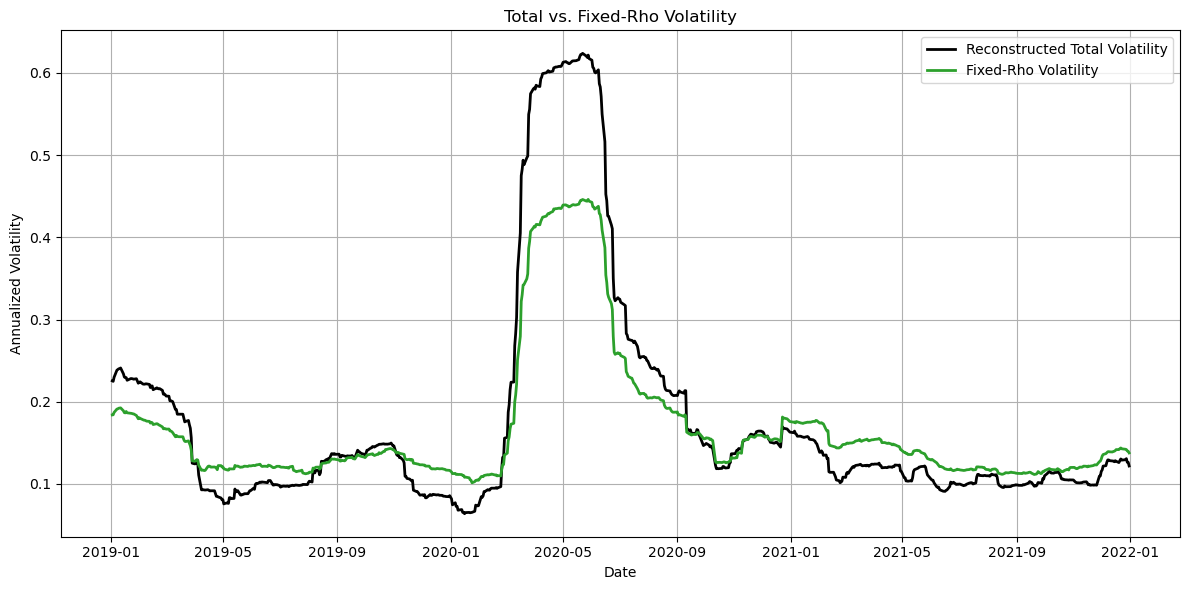

In [168]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_total_vs_fixed(
    df: pd.DataFrame,
    fixed_col: str,
    fixed_label: str,
    start_date: str = None,
    end_date: str = None
):
    """
    Plot Total vs. én af de faste volatilitetserier.

    Args:
      df           : DataFrame med kolonner ['date','vol_total_reconstructed', fixed_col]
      fixed_col    : kolonnenavn for fixed‐serie (f.eks. 'vol_total_fixed_sigma')
      fixed_label  : etiketten i legend (f.eks. 'Fixed‐Sigma Volatility')
      start_date   : (valgfrit) ISO‐string ’YYYY‐MM‐DD’
      end_date     : (valgfrit) ISO‐string ’YYYY‐MM‐DD’
    """
    plot_df = df.copy()
    plot_df["date"] = pd.to_datetime(plot_df["date"])
    if start_date:
        plot_df = plot_df[plot_df["date"] >= pd.to_datetime(start_date)]
    if end_date:
        plot_df = plot_df[plot_df["date"] <= pd.to_datetime(end_date)]

    plt.figure(figsize=(12,6))
    plt.plot(
        plot_df["date"],
        plot_df["vol_total_reconstructed"],
        label="Reconstructed Total Volatility",
        color="black",
        lw=2
    )
    plt.plot(
        plot_df["date"],
        plot_df[fixed_col],
        label=fixed_label,
        color="tab:blue" if "sigma" in fixed_col else "tab:green",
        lw=2
    )

    plt.title(f"Total vs. {fixed_label}")
    plt.xlabel("Date")
    plt.ylabel("Annualized Volatility")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


def plot_both_decompositions(
    df: pd.DataFrame,
    start_date: str = None,
    end_date: str = None
):
    """
    Laver to plots i træk:
      1) Total vs. Fixed‐Sigma
      2) Total vs. Fixed‐Rho
    """
    # 1) Total vs. sigma
    plot_total_vs_fixed(
        df,
        fixed_col="vol_total_fixed_sigma",
        fixed_label="Fixed‐Sigma Volatility",
        start_date=start_date,
        end_date=end_date
    )

    # 2) Total vs. rho
    plot_total_vs_fixed(
        df,
        fixed_col="vol_total_fixed_rho",
        fixed_label="Fixed‐Rho Volatility",
        start_date=start_date,
        end_date=end_date
    )

# Antag decomp_df er det du fik fra decompose_total_variance_fixed_elements(...)
plot_both_decompositions(
    decomp_df,
    start_date="2019-01-01",
    end_date="2021-12-31"
)


### tjek if reconstructed variances are equal dont run

In [ ]:
# 1) Kør begge dekomponerings‐funktioner med identiske parametre
df_fixed = decompose_total_variance_fixed_elements(
    daily_returns_constituents,
    window=21*3,
    fix_to_constant=False,
    min_pct=0.9
)

df_flex = add_all_variance_components(
    index_daily_returns_df,
    daily_returns_constituents,
    window=21*3,
    average_weights=False,
    rho_mean_method="equal",
    min_pct=0.9
).loc[:, ["date", "vol_total_reconstructed"]]

# 2) Merge på dato
comp = (
    df_fixed[["date", "vol_total_reconstructed"]]
    .merge(df_flex, on="date", suffixes=("_fixed", "_flex"))
)

# 3) Se diffs
comp["diff"] = comp["vol_total_reconstructed_fixed"] - comp["vol_total_reconstructed_flex"]
print(comp["diff"].describe())


### rolling correlations

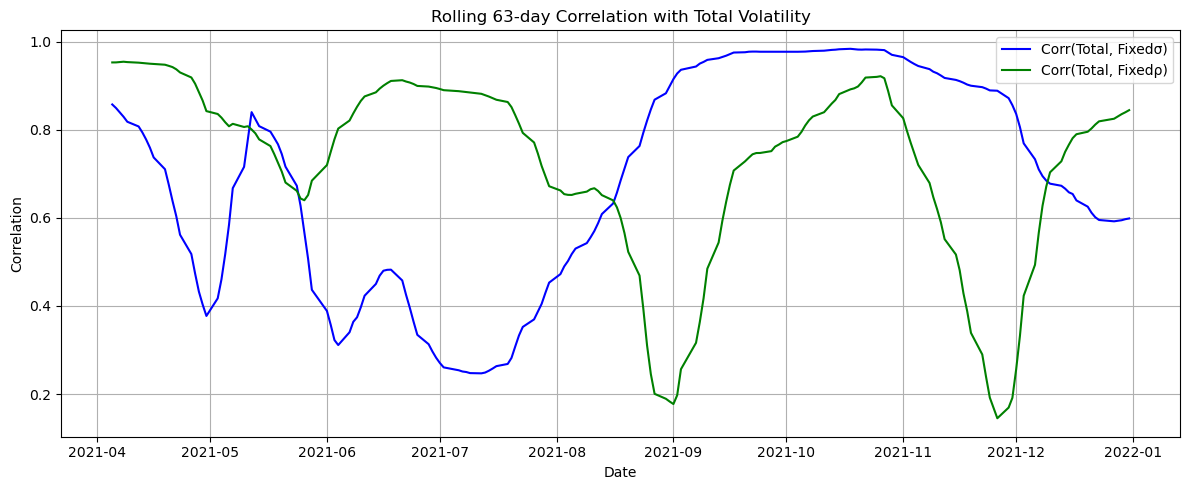

In [169]:
def plot_rolling_corr(df, window=21*3, from_date='1996-01-01', to_date='2023-12-31'):
    df = df.copy()
    df['date'] = pd.to_datetime(df['date'])

    # Filtrér på datoer hvis angivet
    if from_date:
        from_date = pd.to_datetime(from_date)
        df = df[df['date'] >= from_date]
    if to_date:
        to_date = pd.to_datetime(to_date)
        df = df[df['date'] <= to_date]

    ts = df.set_index('date')[[
        'vol_total_reconstructed',
        'vol_total_fixed_sigma',
        'vol_total_fixed_rho'
    ]]

    corr_sig = ts['vol_total_reconstructed'].rolling(window).corr(ts['vol_total_fixed_sigma'])
    corr_rho = ts['vol_total_reconstructed'].rolling(window).corr(ts['vol_total_fixed_rho'])

    plt.figure(figsize=(12,5))
    plt.plot(corr_sig.index, corr_sig, label='Corr(Total, Fixedσ)', color='blue')
    plt.plot(corr_rho.index, corr_rho, label='Corr(Total, Fixedρ)', color='green')
    plt.title(f'Rolling {window}-day Correlation with Total Volatility')
    plt.xlabel('Date'); plt.ylabel('Correlation')
    plt.legend(); plt.grid(True); plt.tight_layout()
    plt.show()

plot_rolling_corr(decomp_df, window=21*3, from_date='2021-01-01', to_date='2021-12-31')


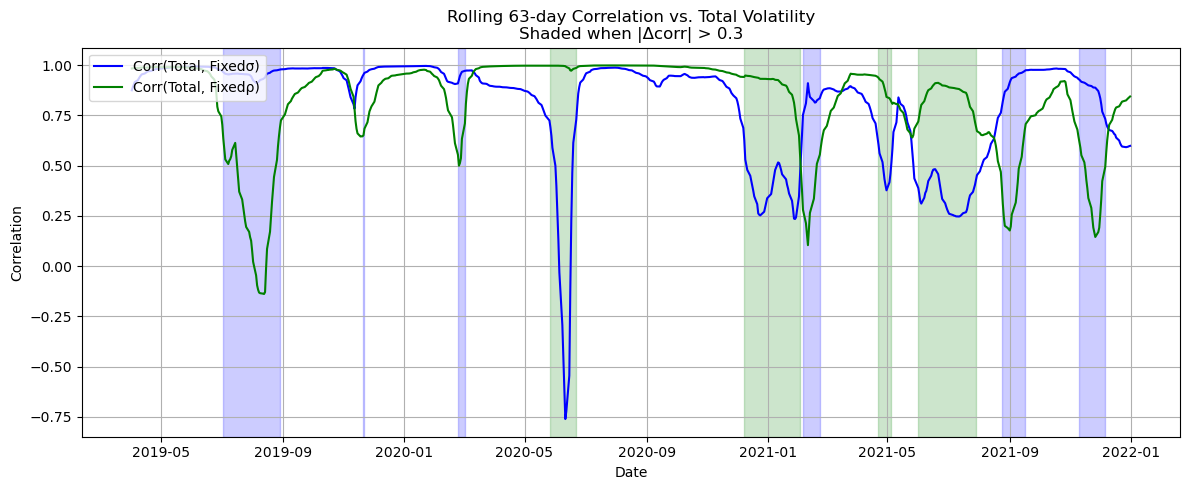

In [170]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_rolling_corr_with_shading(
    df: pd.DataFrame,
    window:     int    = 21*3,
    thresh:     float  = 0.3,
    from_date:  str    = None,
    to_date:    str    = None,
    alpha:      float  = 0.2
):
    """
    Plot rullende korrelation mellem total vol og fixed-σ / fixed-ρ.
    Skygger perioder hvor |corr_sig - corr_rho| > thresh,
    med blå baggrund hvis corr_sig > corr_rho, ellers grøn.
    """
    # Klargør data
    df2 = df.copy()
    df2['date'] = pd.to_datetime(df2['date'])
    if from_date:
        df2 = df2[df2['date'] >= pd.to_datetime(from_date)]
    if to_date:
        df2 = df2[df2['date'] <= pd.to_datetime(to_date)]
    ts = df2.set_index('date')[
        ['vol_total_reconstructed','vol_total_fixed_sigma','vol_total_fixed_rho']
    ]

    # Rullende korrelation
    corr_sig = ts['vol_total_reconstructed'].rolling(window).corr(ts['vol_total_fixed_sigma'])
    corr_rho = ts['vol_total_reconstructed'].rolling(window).corr(ts['vol_total_fixed_rho'])
    diff     = corr_sig - corr_rho

    # Plot basis
    fig, ax = plt.subplots(figsize=(12,5))
    ax.plot(corr_sig.index, corr_sig, label='Corr(Total, Fixedσ)', color='blue')
    ax.plot(corr_rho.index, corr_rho, label='Corr(Total, Fixedρ)', color='green')

    # Helper til shading
    def shade_segments(mask, color):
        in_seg = False
        seg_start = None
        for dt, flag in mask.items():        # <-- brug items() her
            if flag and not in_seg:
                seg_start, in_seg = dt, True
            elif not flag and in_seg:
                ax.axvspan(seg_start, dt, color=color, alpha=alpha)
                in_seg = False
        if in_seg:
            ax.axvspan(seg_start, mask.index[-1], color=color, alpha=alpha)

    # Skift først perioder
    shade_segments(diff >  thresh, 'blue')
    shade_segments(diff < -thresh, 'green')

    ax.set_title(f"Rolling {window}-day Correlation vs. Total Volatility\nShaded when |Δcorr| > {thresh}")
    ax.set_xlabel("Date")
    ax.set_ylabel("Correlation")
    ax.legend(loc="upper left")
    ax.grid(True)
    fig.tight_layout()
    plt.show()


# Eksempel på kald:
plot_rolling_corr_with_shading(
    decomp_df,
    window=21*3,
    thresh=0.3,
    from_date='2019-01-01',
    to_date='2021-12-31',
    alpha=0.2
)


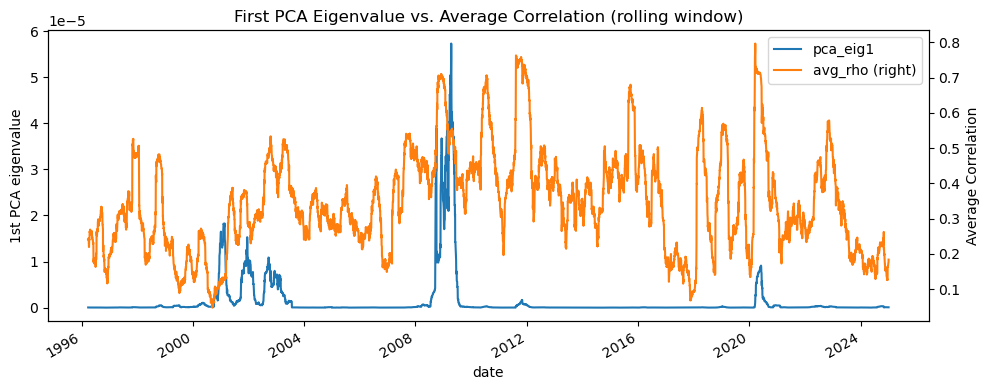

In [171]:
import numpy as np
from sklearn.decomposition import PCA

def rolling_pca_eigen(df_const, window=30):
    """
    Kør PCA på rullevinduer af cov(df) og returner 1. eigenværdi over tid.
    Samtidig beregner vi average pairwise correlation og plotter dem sammen.
    
    df_const    : daily_returns_constituents med ["date","ticker","return"]
    window      : rullevindue i dage
    """
    df_const = df_const.sort_values(["date","ticker"])
    dates = df_const["date"].drop_duplicates().sort_values().to_list()
    
    # pivot returns
    R = df_const.pivot(index="date", columns="ticker", values="return")
    
    records = []
    for i in range(window, len(dates)):
        win = dates[i-window:i]
        sub = R.loc[win].dropna(axis=1, how="any")  # drop tickers med NaN
        if sub.shape[1] < 2:
            continue
        
        # covariance matrix
        C = sub.cov().values
        
        # PCA
        pca = PCA(n_components=1)
        pca.fit(C)
        eig1 = pca.explained_variance_[0]
        
        # avg pairwise corr
        corr = sub.corr().values
        mask = np.triu(np.ones(corr.shape), 1).astype(bool)
        avg_rho = corr[mask].mean()
        
        records.append({
            "date": dates[i],
            "pca_eig1": eig1,
            "avg_rho": avg_rho
        })
    
    return pd.DataFrame(records).set_index("date")

# Eksempel:
pca_df = rolling_pca_eigen(daily_returns_constituents, window=21*3)

# Plot
ax = pca_df.plot(y=["pca_eig1","avg_rho"], secondary_y="avg_rho", figsize=(10,4))
ax.set_ylabel("1st PCA eigenvalue")
ax.right_ax.set_ylabel("Average Correlation")
ax.set_title("First PCA Eigenvalue vs. Average Correlation (rolling window)")
plt.tight_layout()
plt.show()


In [24]:
import statsmodels.api as sm

def rolling_variance_regression(index_df, df_const, window=30):
    """
    For hvert rullevindue regresser:
      σ²_market ~ α + β₁·avg_sigma² + β₂·avg_rho
    
    Returnerer tidsserie af β₁ og β₂.
    
    index_df   : DataFrame med ["date", "return_replicated"] → vi kan bygge σ²_market fra det
    df_const   : daily_returns_constituents med ["date","ticker","return"]
    window     : rullevindue i dage
    """
    # forbered markedets daily variance
    idx = index_df.copy()
    idx["date"] = pd.to_datetime(idx["date"])
    idx = idx.set_index("date")
    idx["var_market"] = idx["return_replicated"].rolling(window).var()
    
    # beregn avg_sigma² og avg_rho hver dag
    # (vi kan genbruge compute_avg_correlation + et simpelt sigma²-lookup)
    # men her laver vi et mini‐loop:
    df_const = df_const.sort_values(["date","ticker"])
    dates = idx.index.to_list()
    
    out = []
    for i in range(window, len(dates)):
        dt = dates[i]
        win = dates[i-window:i]
        
        sub = df_const[df_const["date"].isin(win)]
        R = sub.pivot(index="date", columns="ticker", values="return").dropna(axis=1, how="any")
        if R.shape[1] < 2:
            continue
        
        # avg sigma²
        avg_sigma2 = (R.std()**2).mean()
        
        # avg rho
        C = R.corr().values
        mask = np.triu(np.ones(C.shape),1).astype(bool)
        avg_rho = C[mask].mean()
        
        var_m = float(idx.loc[dt,"var_market"])
        out.append({"date": dt, "var_market": var_m,
                    "avg_sigma2": avg_sigma2, "avg_rho": avg_rho})
    
    reg_df = pd.DataFrame(out).set_index("date").dropna()
    
    # regressions på hele serien: men du kan også gøre det glidende med sm.OLS over sub‐vinduer
    X = reg_df[["avg_sigma2","avg_rho"]]
    X = sm.add_constant(X)
    y = reg_df["var_market"]
    model = sm.OLS(y, X).fit()
    print(model.summary())
    
    # returnér betas over tid (her blot én for hele perioden)
    return model.params, reg_df

# Eksempel:
params, reg_df = rolling_variance_regression(index_daily_returns_df, daily_returns_constituents, window=60)
print("Estimated β₁ (sigma²):", params["avg_sigma2"])
print("Estimated β₂ (rho):",   params["avg_rho"])


                            OLS Regression Results                            
Dep. Variable:             var_market   R-squared:                       0.763
Model:                            OLS   Adj. R-squared:                  0.763
Method:                 Least Squares   F-statistic:                 1.167e+04
Date:                Wed, 30 Apr 2025   Prob (F-statistic):               0.00
Time:                        00:25:40   Log-Likelihood:                 56028.
No. Observations:                7239   AIC:                        -1.120e+05
Df Residuals:                    7236   BIC:                        -1.120e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0002   3.26e-06    -46.591      0.0

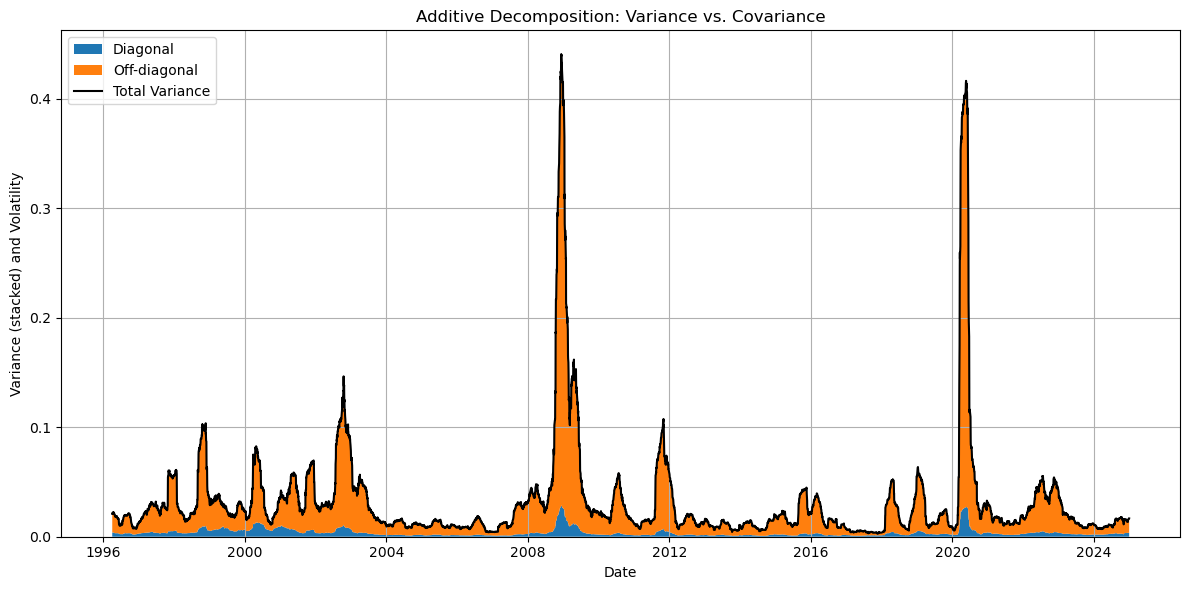

In [147]:
# Antag index_df har allerede dine vol-komponenter annualiseret:
v_var = index_df["vol_variance_component"] ** 2       # variance²
v_cov = index_df["vol_covariance_component"] ** 2     # covariance² (off-diagonal)

plt.figure(figsize=(12,6))
plt.stackplot(
    index_df["date"],
    v_var,
    v_cov,
    labels=["Diagonal", "Off-diagonal"],
    colors=["#1f77b4", "#ff7f0e"]
)
# Total volatilitet (σ) ovenpå:
plt.plot(
    index_df["date"],
    index_df["vol_total_reconstructed"]**2,
    color="black",
    label="Total Variance"
)

plt.title("Additive Decomposition: Variance vs. Covariance")
plt.xlabel("Date")
plt.ylabel("Variance (stacked) and Volatility")
plt.legend(loc="upper left")
plt.grid(True)
plt.tight_layout()
plt.show()


## plots of returns and vol of relicated vs actual index

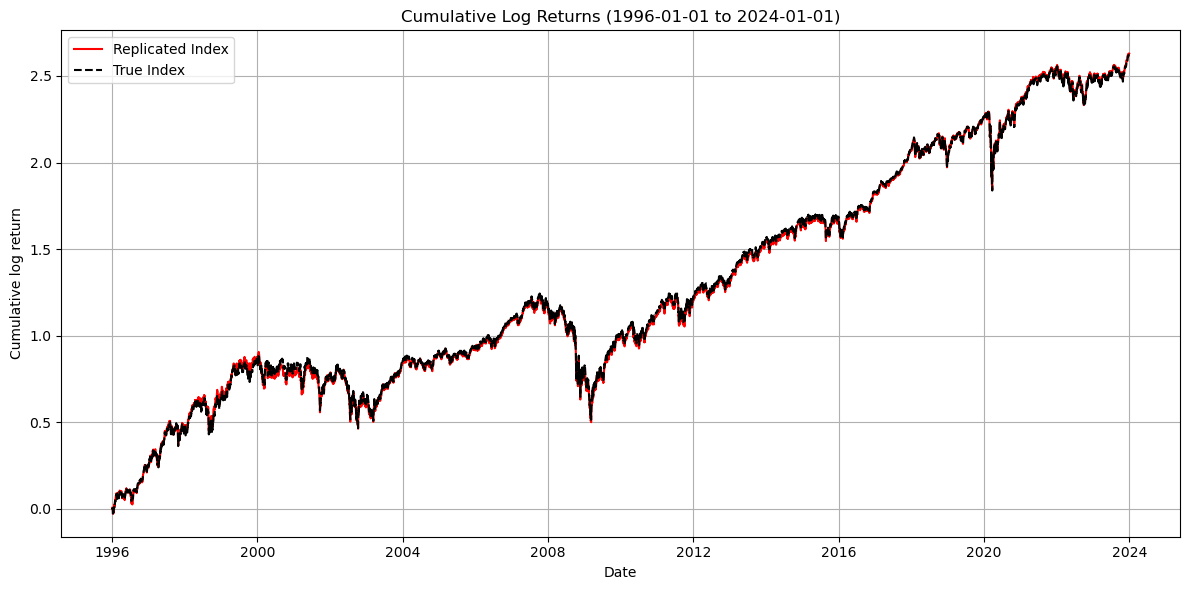

In [172]:
importlib.reload(cor_lib)
cor_lib.plot_log_cumulative_returns(index_daily_returns_df, "1996-01-01", "2024-01-01")


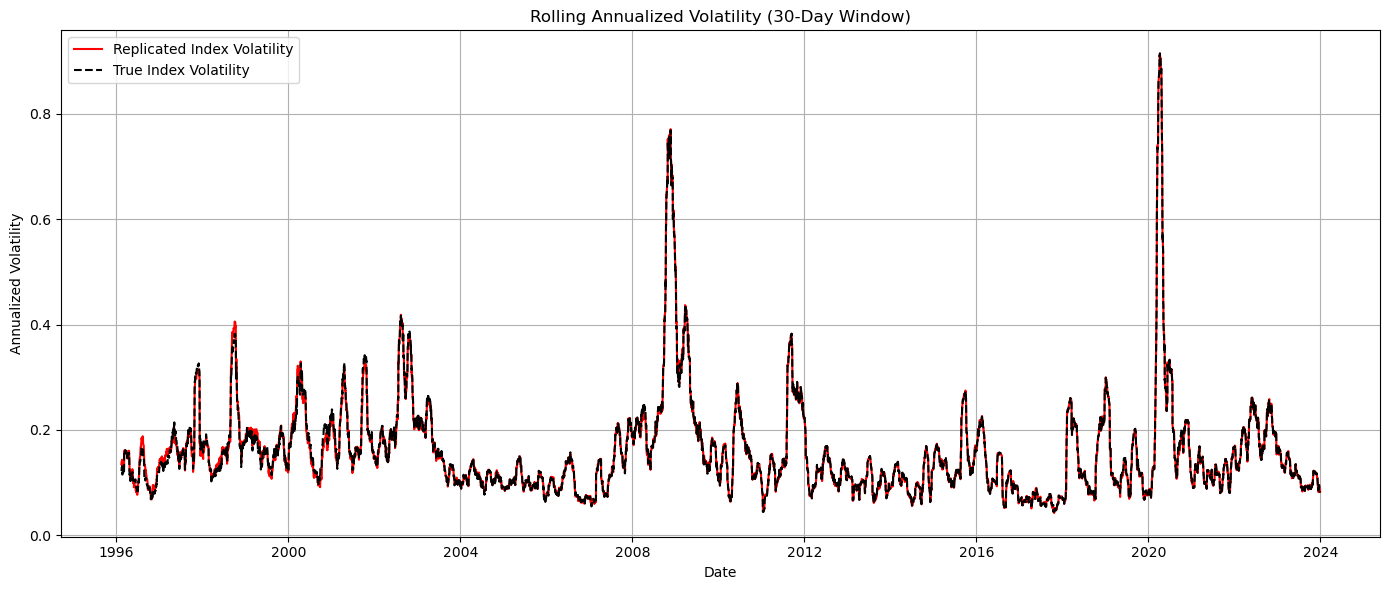

In [173]:
importlib.reload(cor_lib)
cor_lib.plot_rolling_volatility(index_daily_returns_df, "1996-01-01", "2024-01-01")


# Section 3.A 

In [2]:
ticker_list = vp.DJX_tickers + ["OEX"]
sum_df = vtp.concat_ticker_datasets(ticker_list, "sum1")

Skipped 45/50 tickers: ['AA', 'AAPL', 'AIG', 'AMGN', 'AMZN', 'AXP', 'BA', 'BAC', 'C', 'CAT', 'CRM', 'CSCO', 'CVX', 'DD', 'DOW', 'GM', 'GS', 'GT', 'HD', 'HON', 'HPQ', 'INTC', 'IP', 'JNJ', 'JPM', 'KO', 'MCD', 'MMM', 'MO', 'MRK', 'MSFT', 'NKE', 'PFE', 'PG', 'RTX', 'S', 'T', 'TRV', 'UK', 'V', 'VZ', 'WBA', 'WMT', 'XOM', 'OEX']


In [5]:
sum_df = pd.read_csv(r"C:\Users\axell\Desktop\CBS\data\OptionMetrics\Tickers\Output_without_iv_flag\t_\DJX\sum1_df.csv")

### figure 1 

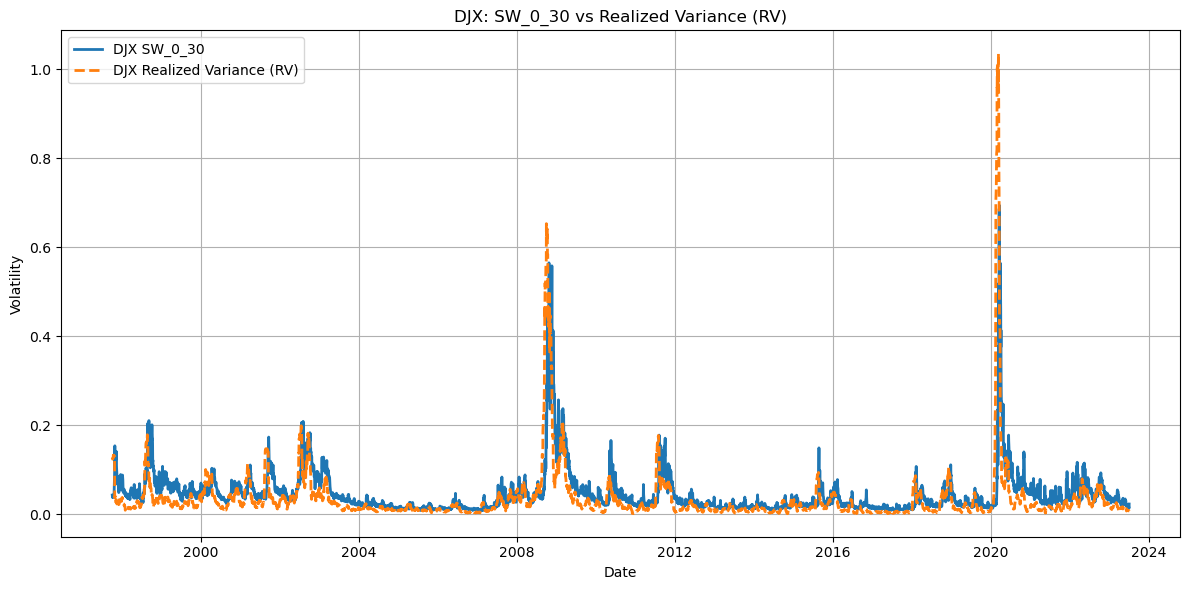

In [3]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_sw_vs_rv(dataframe, ticker, from_date="1996-01-01", to_date="2023-12-31"):
    df = dataframe.copy()
    df['date'] = pd.to_datetime(df['date'])

    # Filtrér for ønsket ticker
    df = df[df["ticker"] == ticker]

    # Filtrér på datoer hvis angivet
    if from_date:
        from_date = pd.to_datetime(from_date)
        df = df[df['date'] >= from_date]
    if to_date:
        to_date = pd.to_datetime(to_date)
        df = df[df['date'] <= to_date]

    # Tjek for duplikate datoer og tag gennemsnit (valgfrit, men fornuftigt)
    df = df.groupby('date')[['SW_0_30', 'RV']].mean().reset_index()

    # Plot
    plt.figure(figsize=(12, 6))
    plt.plot(df["date"], df["SW_0_30"], label=f"{ticker} SW_0_30", linewidth=2)
    plt.plot(df["date"], df["RV"], label=f"{ticker} Realized Variance (RV)", linewidth=2, linestyle='--')
    plt.title(f"{ticker}: SW_0_30 vs Realized Variance (RV)")
    plt.xlabel("Date")
    plt.ylabel("Volatility")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_sw_vs_rv(sum_df, ticker="DJX", from_date="1996-01-01", to_date="2023-06-30")



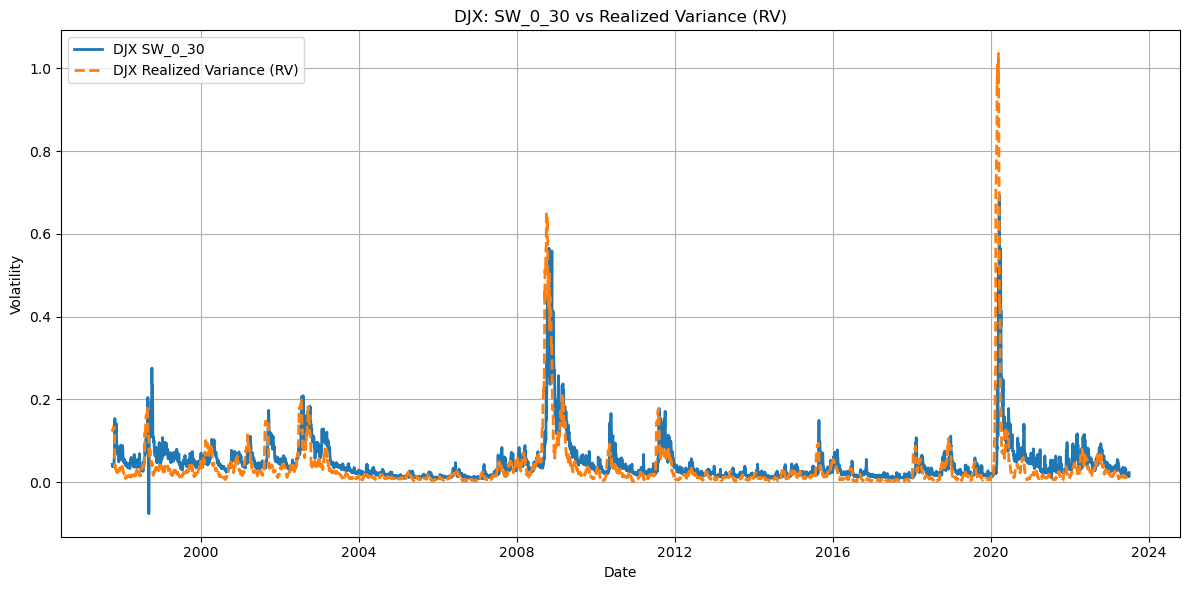

In [6]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_sw_vs_rv(dataframe, ticker, from_date="1996-01-01", to_date="2023-12-31"):
    df = dataframe.copy()
    df['date'] = pd.to_datetime(df['date'])

    # Filtrér for ønsket ticker
    df = df[df["ticker"] == ticker]

    # Filtrér på datoer hvis angivet
    if from_date:
        from_date = pd.to_datetime(from_date)
        df = df[df['date'] >= from_date]
    if to_date:
        to_date = pd.to_datetime(to_date)
        df = df[df['date'] <= to_date]

    # Tjek for duplikate datoer og tag gennemsnit (valgfrit, men fornuftigt)
    df = df.groupby('date')[['SW_0_30', 'RV']].mean().reset_index()

    # Plot
    plt.figure(figsize=(12, 6))
    plt.plot(df["date"], df["SW_0_30"], label=f"{ticker} SW_0_30", linewidth=2)
    plt.plot(df["date"], df["RV"], label=f"{ticker} Realized Variance (RV)", linewidth=2, linestyle='--')
    plt.title(f"{ticker}: SW_0_30 vs Realized Variance (RV)")
    plt.xlabel("Date")
    plt.ylabel("Volatility")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_sw_vs_rv(sum_df, ticker="DJX", from_date="1996-01-01", to_date="2023-06-30")



### figure 2 initial 

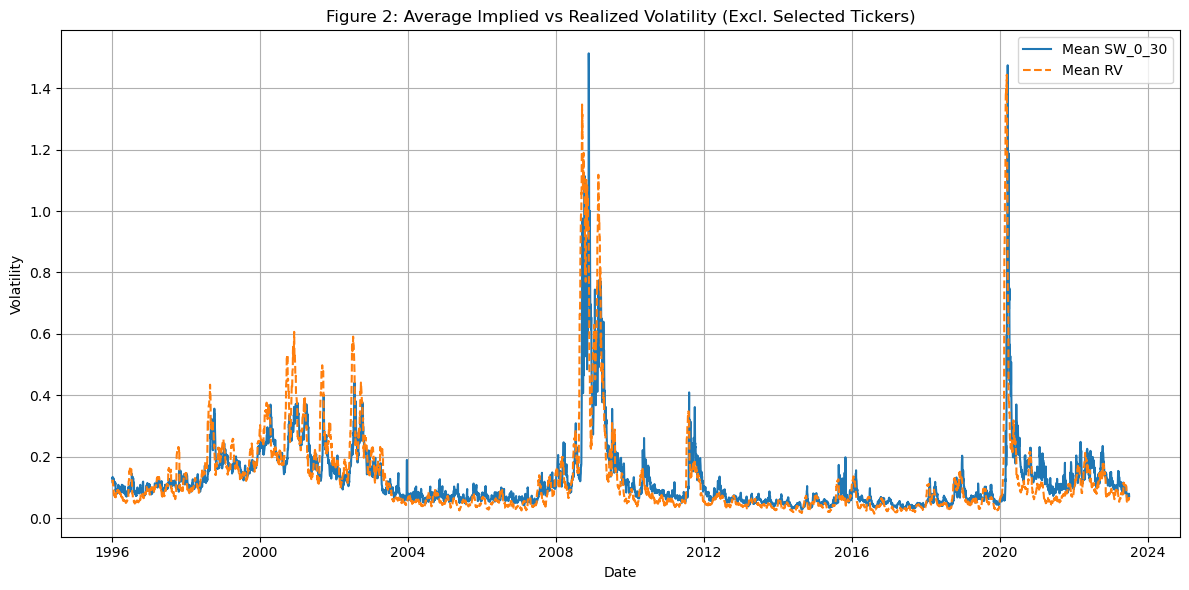

In [277]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_avg_sw_vs_rv_excluding(dataframe, exclude_tickers=None, from_date="1996-01-01", to_date="2023-12-31"):
    df = dataframe.copy()
    df['date'] = pd.to_datetime(df['date'])

    # Ekskludér angivne tickere
    if exclude_tickers:
        df = df[~df['ticker'].isin(exclude_tickers)]

    # Filtrér på datoer hvis angivet
    if from_date:
        from_date = pd.to_datetime(from_date)
        df = df[df['date'] >= from_date]
    if to_date:
        to_date = pd.to_datetime(to_date)
        df = df[df['date'] <= to_date]

    # Beregn gennemsnit pr. dato
    avg_sw = df.groupby("date")["SW_0_30"].mean()
    avg_rv = df.groupby("date")["RV"].mean()

    # Plot
    plt.figure(figsize=(12, 6))
    plt.plot(avg_sw.index, avg_sw.values, label="Mean SW_0_30")
    plt.plot(avg_rv.index, avg_rv.values, label="Mean RV", linestyle="--")
    plt.title("Figure 2: Average Implied vs Realized Volatility (Excl. Selected Tickers)")
    plt.xlabel("Date")
    plt.ylabel("Volatility")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Udeluk DJX og HET fra gennemsnittet
plot_avg_sw_vs_rv_excluding(sum_df, exclude_tickers=["DJX"], from_date="1996-01-01", to_date="2023-06-30")


### investigating negative SW

In [452]:
ticker_list_od = ["DJX", "DIS", "GE", "IBM", "UNH"]

In [468]:
ticker_list = vp.DJX_tickers + ["OEX"]
sum_df = vtp.concat_ticker_datasets(ticker_list, "sum1")

Skipped 48/50 tickers: ['AA', 'AAPL', 'AIG', 'AMGN', 'AMZN', 'AXP', 'BA', 'BAC', 'C', 'CAT', 'CRM', 'CSCO', 'CVX', 'DD', 'DOW', 'GE', 'GM', 'GS', 'GT', 'HD', 'HON', 'HPQ', 'IBM', 'INTC', 'IP', 'JNJ', 'JPM', 'KO', 'MCD', 'MMM', 'MO', 'MRK', 'MSFT', 'NKE', 'PFE', 'PG', 'RTX', 'S', 'T', 'TRV', 'UK', 'UNH', 'V', 'VZ', 'WBA', 'WMT', 'XOM', 'OEX']


In [469]:
od_rdy = vtp.concat_output_ticker_datasets(ticker_list_od, "od_rdy")

In [ ]:
# Sørg for at date-kolonnen er i datetime-format
od_rdy["date"] = pd.to_datetime(od_rdy["date"])

# 2) Definér dine kolonner
cols_to_show = [
    "date", "ticker", "exdate", "cp_flag", "exchange_d", "issue_type", "ss_flag", "F", "K", "IV", "mid", "cp_flag"
]

# 3) Lav masken og filtrér med .loc, så du får netop de kolonner retur
mask = (
    (od_rdy["ticker"] == "DIS") &
    (od_rdy["date"] == pd.Timestamp("1997-11-11"))
)

result = od_rdy.loc[mask, cols_to_show].head(65)

result["rel"] = result["K"]

# 4) Vis resultatet
result



,date,ticker,exdate,cp_flag,exchange_d,issue_type,ss_flag,F,K,IV,mid,cp_flag
1299786,1997-11-11,DIS,1997-11-22,C,1.0,0,0,0.000086,80.0,0.434303,6.56250,C
1299787,1997-11-11,DIS,1997-11-22,C,1.0,0,0,0.000086,90.0,0.264727,0.34375,C
1299788,1997-11-11,DIS,1997-11-22,C,1.0,0,0,0.000086,75.0,0.510062,11.18750,C
1299789,1997-11-11,DIS,1997-11-22,C,1.0,0,0,0.000086,85.0,0.303966,2.34375,C
1299790,1997-11-11,DIS,1997-12-20,C,1.0,0,0,0.000086,80.0,0.375955,7.75000,C
1299791,1997-11-11,DIS,1997-12-20,C,1.0,0,0,0.000086,85.0,0.317647,4.06250,C
1299792,1997-11-11,DIS,1997-12-20,C,1.0,0,0,0.000086,90.0,0.276289,1.56250,C
1299793,1997-11-11,DIS,1998-01-17,C,1.0,0,0,0.000086,75.0,0.403241,12.68750,C
1299794,1997-11-11,DIS,1998-01-17,C,1.0,0,0,0.000086,60.0,0.574898,26.56250,C
1299795,1997-11-11,DIS,1998-01-17,C,1.0,0,0,0.000086,85.0,0.306931,5.00000,C


In [471]:
dftemp = pd.read_csv(r"C:\Users\axell\Desktop\CBS\data\OptionMetrics\Tickers\Input_without_iv_flag\UNH\forward price.csv")

In [472]:
dftemp

,secid,ticker,cusip,issuer,date,expiration,amsettlement,forwardprice
0,111469.0,UNH,91324P10,UNITEDHEALTH GROUP INC,1996-01-04,1996-01-20,0.0,65.664465
1,111469.0,UNH,91324P10,UNITEDHEALTH GROUP INC,1996-01-04,1996-02-17,0.0,65.949383
2,111469.0,UNH,91324P10,UNITEDHEALTH GROUP INC,1996-01-04,1996-03-16,0.0,66.148913
3,111469.0,UNH,91324P10,UNITEDHEALTH GROUP INC,1996-01-04,1996-06-22,0.0,67.158190
4,111469.0,UNH,91324P10,UNITEDHEALTH GROUP INC,1996-01-04,1997-01-18,0.0,69.151714
...,...,...,...,...,...,...,...,...
58826,111469.0,UNH,91324P10,UNITEDHEALTH GROUP INC,2023-08-31,2024-01-19,0.0,482.936975
58827,111469.0,UNH,91324P10,UNITEDHEALTH GROUP INC,2023-08-31,2024-03-15,0.0,485.381297
58828,111469.0,UNH,91324P10,UNITEDHEALTH GROUP INC,2023-08-31,2024-06-21,0.0,491.395790
58829,111469.0,UNH,91324P10,UNITEDHEALTH GROUP INC,2023-08-31,2025-01-17,0.0,503.674117


In [467]:
# Sørg for at datoen er korrekt formateret
dftemp["date"] = pd.to_datetime(dftemp["date"])

# Filtrér for den 11. november 1997
filtered_dftemp = dftemp[dftemp["date"] == "1997-11-11"]

filtered_dftemp

,secid,ticker,cusip,issuer,date,expiration,amsettlement,forwardprice
2870,103879.0,DIS,25468710,WALT DISNEY CO (THE),1997-11-11,1997-11-22,0.0,0.000086
2871,103879.0,DIS,25468710,WALT DISNEY CO (THE),1997-11-11,1997-12-20,0.0,0.000086
2872,103879.0,DIS,25468710,WALT DISNEY CO (THE),1997-11-11,1998-01-17,0.0,0.000086
2873,103879.0,DIS,25468710,WALT DISNEY CO (THE),1997-11-11,1998-04-18,0.0,0.000086
2874,103879.0,DIS,25468710,WALT DISNEY CO (THE),1997-11-11,1999-01-16,0.0,85.867500
2875,103879.0,DIS,25468710,WALT DISNEY CO (THE),1997-11-11,2000-01-22,0.0,85.735000


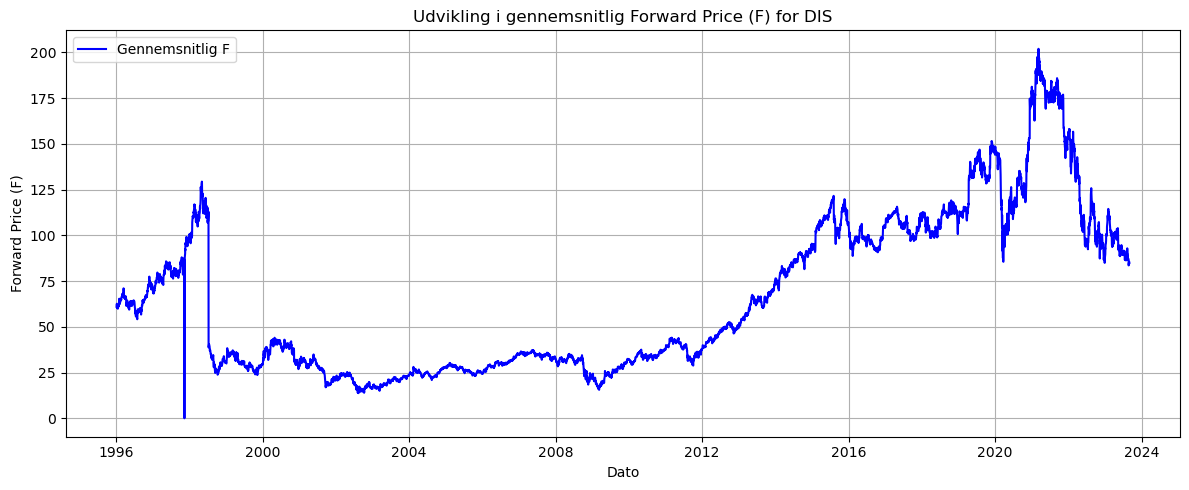

In [461]:
import pandas as pd
import matplotlib.pyplot as plt

# Filtrer på ticker
df_dis = od_rdy[od_rdy["ticker"] == "DIS"].copy()
df_dis["date"] = pd.to_datetime(df_dis["date"])

# Gruppér og tag gennemsnit af F pr. dag
daily_F = df_dis.groupby("date")["F"].mean().reset_index()

# Plot
plt.figure(figsize=(12, 5))
plt.plot(daily_F["date"], daily_F["F"], label="Gennemsnitlig F", color="blue")
plt.title("Udvikling i gennemsnitlig Forward Price (F) for DIS")
plt.xlabel("Dato")
plt.ylabel("Forward Price (F)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [447]:
def tag_outliers_with_details(df, min_abs_diff=0.03, min_rel_diff=1.0):
    """
    Tilføjer kolonner: median_IV, abs_diff, rel_diff og IV_outlier.
    """
    def compute(group):
        med = group["IV"].median()
        group["median_IV"] = med
        group["abs_diff"] = abs(group["IV"] - med)
        group["rel_diff"] = group["abs_diff"] / med
        group["IV_outlier"] = (group["abs_diff"] > min_abs_diff) & (group["rel_diff"] > min_rel_diff)
        return group

    return df.groupby(["ticker", "date", "exdate"], group_keys=False).apply(compute)

result = tag_outliers_with_details(result, min_abs_diff=0.03, min_rel_diff=1.0)

C:\Users\axell\AppData\Local\Temp\ipykernel_42500\1073714351.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return df.groupby(["ticker", "date", "exdate"], group_keys=False).apply(compute)


In [448]:
result

,date,ticker,exdate,cp_flag,exchange_d,issue_type,ss_flag,F,K,IV,mid,cp_flag,IV_outlier,median_IV,abs_diff,rel_diff
1299787,1997-11-11,DIS,1997-11-22,C,1.0,0,0,0.000086,80.0,0.434303,6.56250,C,False,0.369135,0.065168,0.176544
1299788,1997-11-11,DIS,1997-11-22,C,1.0,0,0,0.000086,90.0,0.264727,0.34375,C,False,0.369135,0.104408,0.282844
1299789,1997-11-11,DIS,1997-11-22,C,1.0,0,0,0.000086,75.0,0.510062,11.18750,C,False,0.369135,0.140927,0.381778
1299790,1997-11-11,DIS,1997-11-22,C,1.0,0,0,0.000086,85.0,0.303966,2.34375,C,False,0.369135,0.065169,0.176544
1299791,1997-11-11,DIS,1997-12-20,C,1.0,0,0,0.000086,80.0,0.375955,7.75000,C,False,0.317647,0.058308,0.183562
1299792,1997-11-11,DIS,1997-12-20,C,1.0,0,0,0.000086,85.0,0.317647,4.06250,C,False,0.317647,0.000000,0.000000
1299793,1997-11-11,DIS,1997-12-20,C,1.0,0,0,0.000086,90.0,0.276289,1.56250,C,False,0.317647,0.041358,0.130201
1299794,1997-11-11,DIS,1998-01-17,C,1.0,0,0,0.000086,75.0,0.403241,12.68750,C,False,0.433024,0.029782,0.068778
1299795,1997-11-11,DIS,1998-01-17,C,1.0,0,0,0.000086,60.0,0.574898,26.56250,C,False,0.433024,0.141875,0.327637
1299796,1997-11-11,DIS,1998-01-17,C,1.0,0,0,0.000086,85.0,0.306931,5.00000,C,False,0.433024,0.126092,0.291191


In [414]:
subset = od_rdy_DIS[od_rdy_DIS["optionid"] == 11564392]

# Find min og max dato
min_date = subset["date"].min()
max_date = subset["date"].max()

print("Min date:", min_date)
print("Max date:", max_date)

Min date: 1996-04-10 00:00:00
Max date: 1996-10-17 00:00:00


In [417]:
subset = dftemp2[dftemp2["optionid"] == 11564392]

# Find min og max dato
min_date = subset["date"].min()
max_date = subset["date"].max()

print("Min date:", min_date)
print("Max date:", max_date)

Min date: 1996-04-10
Max date: 1996-10-17


In [408]:
subset = dftemp2[dftemp2["optionid"] == 11564392]

# Find min og max dato
min_date = subset["date"].min()
max_date = subset["date"].max()

print("Min date:", min_date)
print("Max date:", max_date)

Min date: 1996-02-21
Max date: 1996-10-18


In [ ]:
subset = dftemp[dftemp["optionid"] == 11564392]

# Find min og max dato
min_date = subset["date"].min()
max_date = subset["date"].max()

print("Min date:", min_date)
print("Max date:", max_date)

Min date: 1996-02-21
Max date: 1996-10-18


In [304]:
# Antal med negativ 'mid_intrinsic_diff'
num_negative = (od_rdy["mid_intrinsic_diff"] < 0).sum()

# Andel i procent (valgfrit)
percent_negative = 100 * num_negative / len(od_rdy) if len(od_rdy) > 0 else 0

print(f"Antal negative mid_intrinsic_diff: {num_negative}")
print(f"Andel af total: {percent_negative:.2f}%")


Antal negative mid_intrinsic_diff: 0
Andel af total: 0.00%


In [280]:
# Find observationer med negativ SW_0_30
negatives = sum_df[sum_df["SW_0_30"] < 0]

# Find de unikke tickers
negative_tickers = negatives["ticker"].unique()

# Print som en flot streng (med " " rundt om hver ticker)
ticker_string = " ".join(negative_tickers)

print("Tickers med negative SW_0_30 værdier:\n")
print(ticker_string)


Tickers med negative SW_0_30 værdier:

DJX DIS GE IBM UNH


### merging SW and RV to return DF 

In [284]:
# Merge SW_0_30 fra sum_df over på final_df
final_df = daily_returns_constituents.merge(
    sum_df[["date", "ticker", "SW_0_30", "RV", "close"]],
    on=["date", "ticker"],
    how="left"
)

# (valgfrit) Tjek om der mangler noget
print(final_df.head(10))


        date ticker  weight_lag    return  SW_0_30  RV  close
0 1996-01-03     AA    0.037426  0.016092      NaN NaN    NaN
1 1996-01-03    AXP    0.028564  0.005422      NaN NaN    NaN
2 1996-01-03     BA    0.054977 -0.009390      NaN NaN    NaN
3 1996-01-03      C    0.038114  0.006772      NaN NaN    NaN
4 1996-01-03    CAT    0.040953  0.016807      NaN NaN    NaN
5 1996-01-03     DD    0.049557  0.003472      NaN NaN    NaN
6 1996-01-03    DIS    0.041900  0.006160      NaN NaN    NaN
7 1996-01-03     GE    0.050589  0.001701      NaN NaN    NaN
8 1996-01-03     GM    0.035963 -0.007177      NaN NaN    NaN
9 1996-01-03     GT    0.030887 -0.016713      NaN NaN    NaN


## investigatin EXTREME IV VALUES

### positive

In [285]:
# Sorter final_df efter 'SW_0_30' fra højest til lavest
top_swaps = final_df.sort_values(by="RV", ascending=False)

# Vis de 50 største værdier
print(top_swaps.head(50))


            date ticker  weight_lag    return    SW_0_30         RV    close
84976 2008-09-12    AIG    0.013093 -0.308262   8.283574  17.354862  12.1400
84947 2008-09-11    AIG    0.013250  0.002857   4.596375  17.347397  17.5500
84889 2008-09-09    AIG    0.016885 -0.192882   1.817408  16.966303  18.3700
84773 2008-09-03    AIG    0.016287  0.038251   0.612370  16.944520  22.5800
84802 2008-09-04    AIG    0.016738 -0.060230   0.781067  16.928885  21.2200
84831 2008-09-05    AIG    0.016208  0.052780   0.678252  16.900054  22.3400
84860 2008-09-08    AIG    0.017000  0.018800   0.740332  16.866705  22.7600
84918 2008-09-10    AIG    0.013967 -0.047360   2.674321  16.619601  17.5000
84744 2008-09-02    AIG    0.015893  0.021871   0.645353  16.534278  21.9600
85005 2008-09-15    AIG    0.009071 -0.607908  25.005123  16.341874   4.7600
84715 2008-08-29    AIG    0.015676 -0.000930   0.606435  15.211600  21.4900
84686 2008-08-28    AIG    0.014840  0.075500   0.581383  14.769044  21.5100

### negative 

In [286]:
# naegtive SW
top_swaps = final_df.sort_values(by="SW_0_30", ascending=True)

# Vis de 50 største værdier
print(top_swaps.head(50))


             date ticker  weight_lag    return   SW_0_30        RV   close
56340  2004-10-11     GE    0.026784  0.007706 -0.256905  0.022582   34.00
11315  1997-11-11    IBM    0.066818  0.013436 -0.168045  0.112415   99.00
11310  1997-11-11    DIS    0.058439  0.006584 -0.148372  0.086765   86.00
62946  2005-09-06    AXP    0.044029  0.028902  0.004045  0.049005   56.96
56383  2004-10-12   MSFT    0.022211 -0.001069  0.004420  0.032009   28.03
56412  2004-10-13   MSFT    0.022194  0.000000  0.004871  0.032017   28.03
56296  2004-10-07   MSFT    0.022237 -0.012618  0.005648  0.029740   28.17
56238  2004-10-05   MSFT    0.021986  0.009246  0.006501  0.026146   28.38
115770 2013-01-23    JNJ    0.042808  0.002201  0.008869  0.008440   72.85
115799 2013-01-24    JNJ    0.042697  0.003432  0.008901  0.008382   73.10
149744 2017-09-18     KO    0.015135 -0.001516  0.009277  0.011466   46.11
115741 2013-01-22    JNJ    0.043320 -0.007374  0.009450  0.008994   72.69
145461 2017-02-15    JNJ 

In [320]:
import pandas as pd
import numpy as np

def detect_conflict_pct_only_v5(df, forhold_threshold=2.0, diff_threshold=0.5):

    df["moneyness"] = np.log(df["K"] / df["F"])
    df = df.dropna(subset=["IV", "mid", "K", "F"])

    df = df.copy()
    df = df.sort_values(["ticker", "date", "exdate", "cp_flag", "moneyness", "mid"]).reset_index(drop=True)

    df["group_id"] = df.groupby(["ticker", "date", "exdate", "cp_flag"]).ngroup()

    df["prev_conflict_rate"] = 0.0
    df["next_conflict_rate"] = 0.0

    results = []

    for group_id, group in df.groupby("group_id", group_keys=False):
        mids = group["mid"].values
        cp_flag = group["cp_flag"].iloc[0]
        n = len(mids)

        if n < 2:
            prev_rates = np.zeros(n)
            next_rates = np.zeros(n)
        else:
            mids_matrix = np.tile(mids, (n, 1))

            if cp_flag == "C":
                prev_conflicts = (mids_matrix[:, :].T < mids).T
                next_conflicts = (mids_matrix[:, :].T > mids).T
            else:
                prev_conflicts = (mids_matrix[:, :].T > mids).T
                next_conflicts = (mids_matrix[:, :].T < mids).T

            np.fill_diagonal(prev_conflicts, False)
            np.fill_diagonal(next_conflicts, False)

            prev_rates = np.zeros(n)
            next_rates = np.zeros(n)

            for i in range(n):
                prev_rates[i] = prev_conflicts[i, :i].mean() if i > 0 else 0
                next_rates[i] = next_conflicts[i, (i+1):].mean() if i < n-1 else 0

        result = pd.DataFrame({
            "index": group.index,
            "prev_conflict_rate": prev_rates,
            "next_conflict_rate": next_rates
        })
        results.append(result)

    conflict_rates_df = pd.concat(results).set_index("index")
    df.loc[conflict_rates_df.index, ["prev_conflict_rate", "next_conflict_rate"]] = conflict_rates_df[["prev_conflict_rate", "next_conflict_rate"]]

    df["combined_conflict_rate"] = df["prev_conflict_rate"] + df["next_conflict_rate"]
    df["conflict_arb_flag"] = (df["combined_conflict_rate"] >= 0.75).astype(int)

    ### --- NY DEL: Beregn BIG_FLAG med forhold OG difference --- ###
    df["big_flag"] = 0

    for group_id, group in df.groupby("group_id", group_keys=False):
        mids = group["mid"].values
        cp_flag = group["cp_flag"].iloc[0]
        n = len(mids)

        for i in range(n):
            if group["conflict_arb_flag"].iloc[i] == 1:
                mid = mids[i]
                prev_mids = mids[:i]
                next_mids = mids[(i+1):]

                # Tjek prev
                if len(prev_mids) > 0:
                    prev_ratio = np.mean(mid / prev_mids)
                    prev_diff = np.mean(np.abs(mid - prev_mids))

                    if cp_flag == "C" and prev_ratio > forhold_threshold and prev_diff > diff_threshold:
                        df.loc[group.index[i], "big_flag"] = 1
                    if cp_flag == "P" and prev_ratio < 1/forhold_threshold and prev_diff > diff_threshold:
                        df.loc[group.index[i], "big_flag"] = 1

                # Tjek next
                if len(next_mids) > 0:
                    next_ratio = np.mean(mid / next_mids)
                    next_diff = np.mean(np.abs(mid - next_mids))

                    if cp_flag == "C" and next_ratio < 1/forhold_threshold and next_diff > diff_threshold:
                        df.loc[group.index[i], "big_flag"] = 1
                    if cp_flag == "P" and next_ratio > forhold_threshold and next_diff > diff_threshold:
                        df.loc[group.index[i], "big_flag"] = 1

    # Lav group summary
    group_summary = df.groupby(["ticker", "date", "exdate", "cp_flag"]).agg(
        n_options=("mid", "count"),
        has_conflict=("conflict_arb_flag", "max"),
        has_big_conflict=("big_flag", "max")
    ).reset_index()

    return df.drop(columns=["group_id"]), group_summary



In [291]:
od_investigated, od_invesigated_summary = detect_conflict_pct_only_v5(od_rdy, forhold_threshold=2.0, diff_threshold=0.5)

In [329]:
import pandas as pd
import numpy as np

# Antag at final_df og final_summary allerede er klar fra tidligere

# Først: filtrér grupper der har konflikter
# conflict_groups = od_invesigated_summary[od_invesigated_summary["has_big_conflict"] == 1]

conflict_groups = od_invesigated_summary[
    (od_invesigated_summary["has_big_conflict"] == 1) &
    (od_invesigated_summary["date"] < "2000-01-01")
]


# Træk et tilfældigt eksempel
example_group = conflict_groups.sample(1)  # Tilføj evt. random_state=42 hvis du vil reproducere

# Filtrer fra hele det samlede datasæt
example_data = od_investigated[
    (od_investigated["ticker"] == example_group["ticker"].values[0]) &
    (od_investigated["date"] == example_group["date"].values[0]) &
    (od_investigated["exdate"] == example_group["exdate"].values[0]) &
    (od_investigated["cp_flag"] == example_group["cp_flag"].values[0])
]

# Udskriv relevante kolonner
example_data[["date", "ticker", "exdate", "cp_flag", "exchange_d", "issue_type", "ss_flag", "mid_intrinsic_diff",  "F", "K", "IV", "moneyness", "mid","prev_conflict_rate", "next_conflict_rate", "combined_conflict_rate", "conflict_arb_flag", "big_flag"]].head(40)


# Index(['ticker', 'issuer', 'optionid', 'date', 'exdate', 'cp_flag', 'K', 'bid',
#        'ask', 'IV_om', 'volume', 'issue_type', 'exchange_d', 'ss_flag', 'mid',
#        'n_trading_day', 'n_trading_day_exdate', 't_days', 't_TTM', 'c_days',
#        'c_TTM', 'F', 'IV', 'intrinsic', 'mid_intrinsic_diff', 'spread', 'r'],


,date,ticker,exdate,cp_flag,exchange_d,issue_type,ss_flag,mid_intrinsic_diff,F,K,IV,moneyness,mid,prev_conflict_rate,next_conflict_rate,combined_conflict_rate,conflict_arb_flag,big_flag
964006,1998-09-24,DJX,1998-11-21,P,32768.0,A,0,0.8125,80.450186,64.0,0.492171,-0.228755,0.8125,0.000000,0.0,0.000000,0,0
964007,1998-09-24,DJX,1998-11-21,P,32768.0,A,0,0.8750,80.450186,65.0,0.478027,-0.213251,0.8750,0.000000,0.0,0.000000,0,0
964008,1998-09-24,DJX,1998-11-21,P,32768.0,A,0,11.8125,80.450186,66.0,1.611545,-0.197983,11.8125,0.000000,1.0,1.000000,1,1
964009,1998-09-24,DJX,1998-11-21,P,32768.0,A,0,1.0625,80.450186,67.0,0.456537,-0.182946,1.0625,0.333333,0.0,0.333333,0,0
964010,1998-09-24,DJX,1998-11-21,P,32768.0,A,0,1.1875,80.450186,68.0,0.448134,-0.168130,1.1875,0.250000,0.0,0.250000,0,0
964011,1998-09-24,DJX,1998-11-21,P,32768.0,A,0,1.3125,80.450186,69.0,0.438061,-0.153532,1.3125,0.200000,0.0,0.200000,0,0
964012,1998-09-24,DJX,1998-11-21,P,32768.0,A,0,1.4375,80.450186,70.0,0.426474,-0.139143,1.4375,0.166667,0.0,0.166667,0,0
964013,1998-09-24,DJX,1998-11-21,P,32768.0,A,0,1.5625,80.450186,71.0,0.413478,-0.124958,1.5625,0.142857,0.0,0.142857,0,0
964014,1998-09-24,DJX,1998-11-21,P,32768.0,A,0,1.7500,80.450186,72.0,0.405864,-0.110972,1.7500,0.125000,0.0,0.125000,0,0
964015,1998-09-24,DJX,1998-11-21,P,32768.0,A,0,1.9375,80.450186,73.0,0.396267,-0.097179,1.9375,0.111111,0.0,0.111111,0,0


In [294]:
# Gruppering på ticker-niveau
ticker_summary = od_invesigated_summary.groupby("ticker").agg(
    total_groups=("ticker", "count"),
    conflict_groups=("has_conflict", "sum"),
    big_conflict_groups=("has_big_conflict", "sum")
).reset_index()

# Sortér så vi ser tickere med flest big conflicts først
ticker_summary = ticker_summary.sort_values(by=["big_conflict_groups", "conflict_groups"], ascending=False)

# Udskriv de første 10
ticker_summary.head(10)


,ticker,total_groups,conflict_groups,big_conflict_groups
4,UNH,94287,10315,967
3,IBM,98176,7858,352
2,GE,103035,4084,212
0,DIS,94852,4230,200
1,DJX,82565,1732,56


### other outlier analysis based on IV and close neighbors

In [ ]:
def mad_based_outlier(series, threshold=5.0, min_abs_diff=0.03):
    """
    Marker outliers baseret på MAD, men kræv også absolut afvigelse.
    """
    if len(series) <= 3:
        return pd.Series([False] * len(series), index=series.index)

    med = series.median()
    mad = np.median(np.abs(series - med)) if med > 0 else 0
    abs_diff = np.abs(series - med)

    if mad == 0:
        return pd.Series([False] * len(series), index=series.index)

    return (abs_diff > threshold * mad) & (abs_diff > min_abs_diff)


# Gruppér på ticker, date, exdate, cp_flag
od_rdy["IV_outlier"] = od_rdy.groupby(["ticker", "date", "exdate", "cp_flag"])["IV"].transform(
    lambda group: mad_based_outlier(group, threshold=5.0, min_abs_diff=2)
)


In [373]:
def abs_diff_outlier(series, min_abs_diff=0.03):
    """
    Marker outliers som observationer med absolut afvigelse fra medianen > min_abs_diff.
    Ingen brug af MAD.
    """
    if len(series) <= 3:
        return pd.Series([False] * len(series), index=series.index)

    med = series.median()
    abs_diff = np.abs(series - med)

    return abs_diff > min_abs_diff

# Brug ny funktion med fx 3 vol-points som grænse (0.03)
od_rdy["IV_outlier"] = od_rdy.groupby(["ticker", "date", "exdate", "cp_flag"])["IV"].transform(
    lambda group: abs_diff_outlier(group, min_abs_diff=1)
)


In [374]:
num_outliers = od_rdy["IV_outlier"].sum()
total_obs = len(od_rdy)
percent = 100 * num_outliers / total_obs if total_obs > 0 else 0

print(f"Antal IV-outliers: {num_outliers}")
print(f"Andel af datasættet: {percent:.2f}%")


Antal IV-outliers: 523
Andel af datasættet: 0.01%


In [375]:
outliers_per_ticker = od_rdy.groupby("ticker")["IV_outlier"].sum().sort_values(ascending=False)
print(outliers_per_ticker.head(10))


ticker
UNH    216
GE     189
IBM     42
DIS     40
DJX     36
Name: IV_outlier, dtype: int64


In [379]:
# Kolonner du vil vise
cols_to_show = [
    "date", "ticker", "exdate", "cp_flag", "exchange_d", "issue_type", "ss_flag",
    "mid_intrinsic_diff", "F", "K", "IV", "moneyness", "mid", "IV_outlier"
]

# Sæt dato-grænse
cutoff_date = pd.to_datetime("2000-01-01")

# 1. Find grupper med mindst én IV-outlier og date < cutoff
groups_with_outlier = (
    od_rdy[
        (od_rdy["IV_outlier"]) &
        (od_rdy["date"] < cutoff_date)
    ][["ticker", "date", "exdate"]]
    .drop_duplicates()
)

# 2. Træk tilfældig gruppe
random_group = groups_with_outlier.sample(1).iloc[0]

# 3. Filtrér data for netop denne gruppe
sample_group = od_rdy[
    (od_rdy["ticker"] == random_group["ticker"]) &
    (od_rdy["date"] == random_group["date"]) &
    (od_rdy["exdate"] == random_group["exdate"])
]

# 4. Vis
sample_group[cols_to_show].head(20)


,date,ticker,exdate,cp_flag,exchange_d,issue_type,ss_flag,mid_intrinsic_diff,F,K,IV,moneyness,mid,IV_outlier
17363,1998-09-18,DJX,1998-11-21,P,32768.0,A,0,2.06250,79.427964,71.0,0.422623,-0.112171,2.06250,False
17364,1998-09-18,DJX,1998-11-21,C,32768.0,A,0,2.50000,79.427964,83.0,0.302071,0.043990,2.50000,False
17365,1998-09-18,DJX,1998-11-21,P,32768.0,A,0,3.37500,79.427964,76.0,0.383462,-0.044117,3.37500,False
17366,1998-09-18,DJX,1998-11-21,P,32768.0,A,0,1.87500,79.427964,70.0,0.431821,-0.126355,1.87500,False
17367,1998-09-18,DJX,1998-11-21,P,32768.0,A,0,1.50000,79.427964,68.0,0.444740,-0.155343,1.50000,False
17368,1998-09-18,DJX,1998-11-21,P,32768.0,A,0,2.25000,79.427964,72.0,0.411776,-0.098184,2.25000,False
17369,1998-09-18,DJX,1998-11-21,C,32768.0,A,0,1.06250,79.427964,87.0,0.267559,0.091058,1.06250,False
17370,1998-09-18,DJX,1998-11-21,P,32768.0,A,0,3.12500,79.427964,75.0,0.396261,-0.057362,3.12500,False
17371,1998-09-18,DJX,1998-11-21,C,32768.0,A,0,0.81250,79.427964,88.0,0.259136,0.102486,0.81250,False
17372,1998-09-18,DJX,1998-11-21,P,32768.0,A,0,12.68750,79.427964,66.0,1.589843,-0.185196,12.68750,True


In [ ]:
import pandas as pd
import numpy as np

# Antag at final_df og final_summary allerede er klar fra tidligere

# Først: filtrér grupper der har konflikter
conflict_groups = final_summary_detection[final_summary_detection["has_big_conflict"] == 1]

# Træk et tilfældigt eksempel
example_group = conflict_groups.sample(1)  # Tilføj evt. random_state=42 hvis du vil reproducere

# Filtrer fra hele det samlede datasæt
example_data = final_df_detection[
    (final_df_detection["ticker"] == example_group["ticker"].values[0]) &
    (final_df_detection["date"] == example_group["date"].values[0]) &
    (final_df_detection["exdate"] == example_group["exdate"].values[0]) &
    (final_df_detection["cp_flag"] == example_group["cp_flag"].values[0])
]

# Udskriv relevante kolonner
example_data[["date", "ticker", "exdate", "cp_flag", "F", "K", "IV", "moneyness", "mid","prev_conflict_rate", "next_conflict_rate", "combined_conflict_rate", "conflict_arb_flag", "big_flag"]].head(40)


,date,ticker,exdate,cp_flag,F,K,IV,moneyness,mid,prev_conflict_rate,next_conflict_rate,combined_conflict_rate,conflict_arb_flag,big_flag
1212465,2003-09-25,MMM,2003-11-22,P,141.102291,60.0,3.537908,-0.855141,18.950,0.000000,1.0,1.000000,1,1
1212466,2003-09-25,MMM,2003-11-22,P,141.102291,120.0,0.273016,-0.161993,0.425,1.000000,0.0,1.000000,1,1
1212467,2003-09-25,MMM,2003-11-22,P,141.102291,125.0,0.253220,-0.121171,0.750,0.500000,0.0,0.500000,0,0
1212468,2003-09-25,MMM,2003-11-22,P,141.102291,130.0,0.232821,-0.081951,1.300,0.333333,0.0,0.333333,0,0
1212469,2003-09-25,MMM,2003-11-22,P,141.102291,135.0,0.217402,-0.044210,2.325,0.250000,0.0,0.250000,0,0
1212470,2003-09-25,MMM,2003-11-22,P,141.102291,140.0,0.205158,-0.007843,4.050,0.200000,0.0,0.200000,0,0


In [ ]:
# Gruppering på ticker-niveau
ticker_summary = final_summary_detection.groupby("ticker").agg(
    total_groups=("ticker", "count"),
    conflict_groups=("has_conflict", "sum"),
    big_conflict_groups=("has_big_conflict", "sum")
).reset_index()

# Sortér så vi ser tickere med flest big conflicts først
ticker_summary = ticker_summary.sort_values(by=["big_conflict_groups", "conflict_groups"], ascending=False)

# Udskriv de første 10
ticker_summary.head(10)


,ticker,total_groups,conflict_groups,big_conflict_groups
9,BAX,4755,10,10
40,MMM,7408,9,6
5,ATI,1316,13,2
48,PFE,7556,42,1
43,MS,6958,301,0
60,WFC,4542,174,0
55,TWX,6719,103,0
52,SLB,7295,62,0
30,IBM,8027,61,0
56,TXN,7844,59,0


## creating final summary df to plot over time 

In [328]:
# Fjern tickers du ikke vil have
tickers_to_remove = ["BAX", "MMM", "ATI", "PFE"]
final_df_remove_extreme = final_df[~final_df["ticker"].isin(tickers_to_remove)]

# Ligevægtet gennemsnit UDEN dropna
equal_weighted = (
    final_df_remove_extreme
    .groupby("date")
    .agg(
        SW_0_30_equalweight=("SW_0_30", "mean"),
        RV_equalweight=("RV", "mean")
    )
)

# Cap-weighted gennemsnit (skal stadig droppe NaN, ellers vægte gange NaN bliver skævt)
cap_weighted = (
    final_df_remove_extreme.dropna(subset=["SW_0_30", "RV"])
    .assign(
        weighted_sw=lambda x: x["SW_0_30"] * x["weight"],
        weighted_rv=lambda x: x["RV"] * x["weight"]
    )
    .groupby("date")
    .agg(
        SW_0_30_capweight=("weighted_sw", "sum"),
        RV_capweight=("weighted_rv", "sum")
    )
)

# Saml det hele
summary_df = pd.concat([equal_weighted, cap_weighted], axis=1)

# Se resultat
print(summary_df.head())


            SW_0_30_equalweight  RV_equalweight  SW_0_30_capweight  \
date                                                                 
1996-01-03                  NaN             NaN                NaN   
1996-01-04             0.130367        0.106884           0.040514   
1996-01-05             0.144463        0.104224           0.043005   
1996-01-08             0.153084        0.107024           0.047472   
1996-01-09             0.121260        0.110046           0.060140   

            RV_capweight  
date                      
1996-01-03           NaN  
1996-01-04      0.046583  
1996-01-05      0.046871  
1996-01-08      0.049671  
1996-01-09      0.063634  


In [340]:
import pandas as pd

# Parametre
tickers_to_remove = ["BAX", "MMM", "ATI", "PFE"]
n_select = 20  # fx vælg top 50 mest likvide tickere

# Fjern uønskede tickere
final_df_remove_extreme = final_df[~final_df["ticker"].isin(tickers_to_remove)]

# 1. Beregn NaN-ratio for hver ticker
nan_ratio = (
    final_df_remove_extreme
    .groupby("ticker")["SW_0_30"]
    .apply(lambda x: x.isna().mean())
)

# 2. Vælg top n_select tickere med lavest NaN-ratio
top_liquid_tickers = nan_ratio.sort_values().head(n_select).index.tolist()

# 3. Filtrér datasættet til kun de bedste tickere
final_df_liquid = final_df_remove_extreme[final_df_remove_extreme["ticker"].isin(top_liquid_tickers)]

# 4. Ligevægtet gennemsnit (uden dropna på hele rækker)
equal_weighted = (
    final_df_liquid
    .groupby("date")
    .agg(
        SW_0_30_equalweight=("SW_0_30", "mean"),
        RV_equalweight=("RV", "mean")
    )
)

# 5. Cap-weighted gennemsnit (her dropper vi stadig NaN's inden vægtning)
cap_weighted = (
    final_df_liquid.dropna(subset=["SW_0_30", "RV"])
    .assign(
        weighted_sw=lambda x: x["SW_0_30"] * x["weight"],
        weighted_rv=lambda x: x["RV"] * x["weight"]
    )
    .groupby("date")
    .agg(
        SW_0_30_capweight=("weighted_sw", "sum"),
        RV_capweight=("weighted_rv", "sum")
    )
)

# 6. Saml alt
summary_df = pd.concat([equal_weighted, cap_weighted], axis=1)

# 7. Se resultat
print(summary_df.head())


            SW_0_30_equalweight  RV_equalweight  SW_0_30_capweight  \
date                                                                 
1996-01-03                  NaN             NaN                NaN   
1996-01-04             0.172975        0.149063           0.018363   
1996-01-05             0.159824        0.143962           0.017185   
1996-01-08             0.175286        0.153089           0.018812   
1996-01-09             0.125296        0.158621           0.021699   

            RV_capweight  
date                      
1996-01-03           NaN  
1996-01-04      0.025735  
1996-01-05      0.025429  
1996-01-08      0.027325  
1996-01-09      0.031996  


### maybe clean if not enough active trade days 

In [236]:
# Hvilke tickere mangler oftest SW_0_30?
missing_sw = final_df[final_df["SW_0_30"].isna()]
print(missing_sw["ticker"].value_counts().head(10))


ticker
SO     7211
DOW    6841
DD     6296
F      6176
WFC    6160
T      6131
EXC    6120
GM     6105
RTN    6042
CL     5783
Name: count, dtype: int64


### plotting over time eq weighted and cap weighted

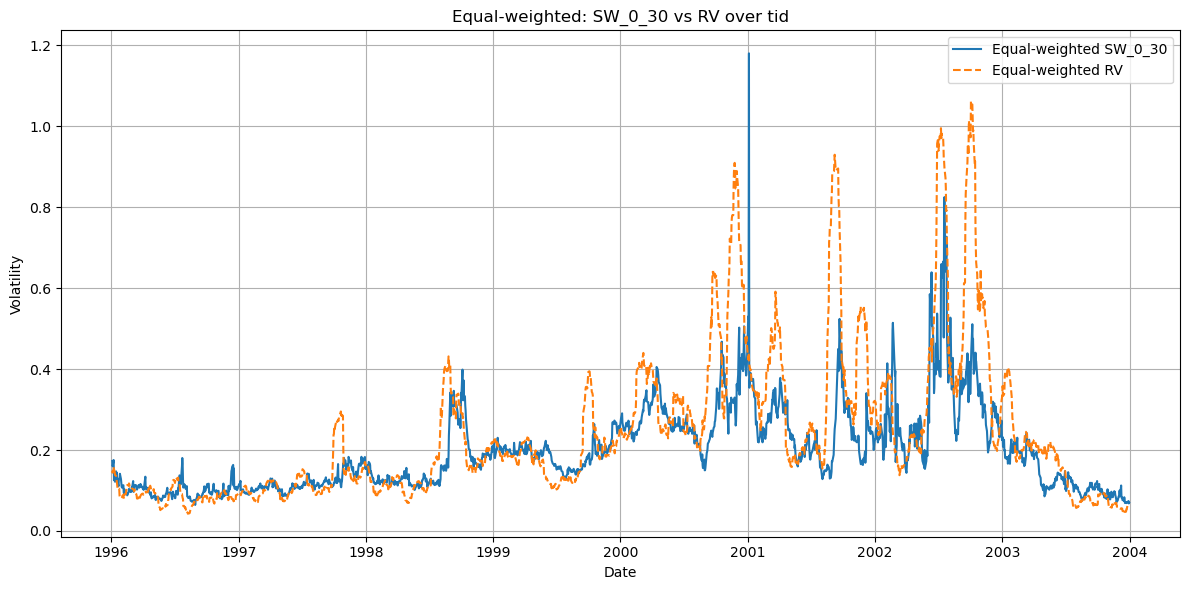

In [341]:
import matplotlib.pyplot as plt

# Plot Equal-weighted
plt.figure(figsize=(12, 6))
plt.plot(summary_df.index, summary_df["SW_0_30_equalweight"], label="Equal-weighted SW_0_30")
plt.plot(summary_df.index, summary_df["RV_equalweight"], label="Equal-weighted RV", linestyle="--")
plt.title("Equal-weighted: SW_0_30 vs RV over tid")
plt.xlabel("Date")
plt.ylabel("Volatility")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


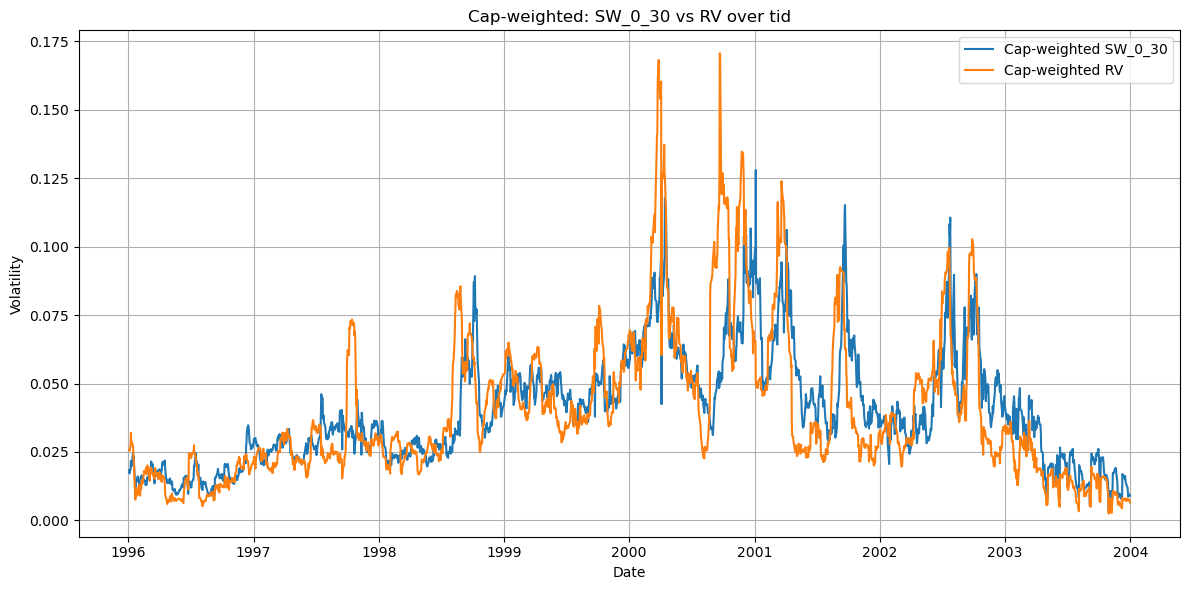

In [343]:
# Plot Cap-weighted
plt.figure(figsize=(12, 6))
plt.plot(summary_df.index, summary_df["SW_0_30_capweight"], label="Cap-weighted SW_0_30")
plt.plot(summary_df.index, summary_df["RV_capweight"], label="Cap-weighted RV", linestyle="-")
plt.title("Cap-weighted: SW_0_30 vs RV over tid")
plt.xlabel("Date")
plt.ylabel("Volatility")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### vrp average pr ticker

c:\Users\axell\anaconda3\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\axell\anaconda3\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


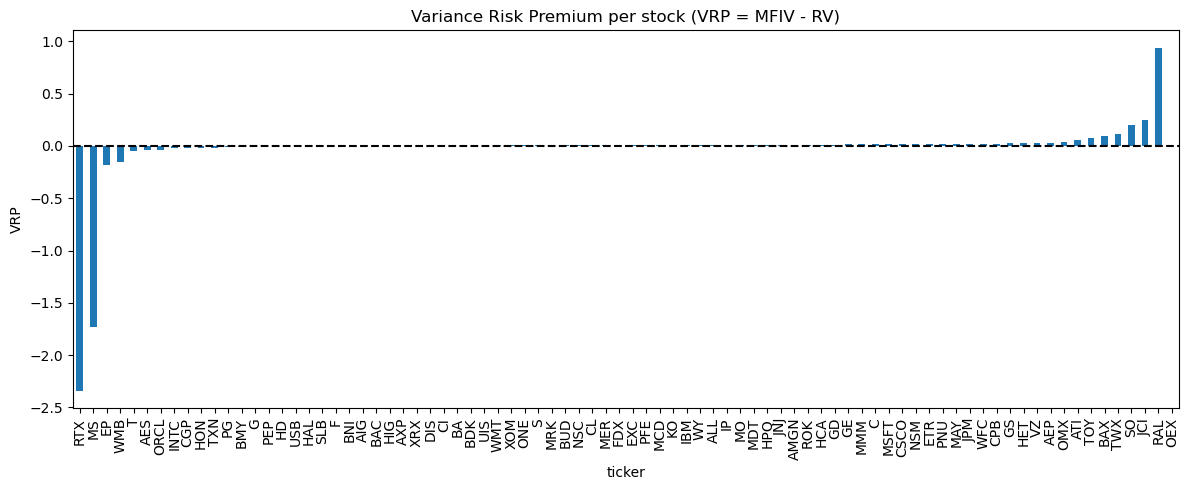

In [142]:
# Lav kopi med relevante kolonner
df_vrp = sum_df[["ticker", "date", "SW_0_30", "RV"]].copy()

# Beregn MFIV, VRP og log-ratio
df_vrp["MFIV"] = df_vrp["SW_0_30"]
df_vrp["VRP"] = df_vrp["MFIV"] - df_vrp["RV"]
df_vrp["log_RV_MFIV"] = np.log(df_vrp["RV"] / df_vrp["MFIV"])

# Gennemsnit pr. ticker
vrp_per_stock = df_vrp.groupby("ticker")[["VRP", "log_RV_MFIV"]].mean().sort_values("VRP")

# (Valgfrit) plot
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
vrp_per_stock["VRP"].plot(kind="bar")
plt.axhline(0, color="black", linestyle="--")
plt.title("Variance Risk Premium per stock (VRP = MFIV - RV)")
plt.ylabel("VRP")
plt.tight_layout()
plt.show()


### table 1 (data to table 1)

In [127]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.regression.linear_model import OLS
from statsmodels.tools.tools import add_constant

# Antag df_orpy eksisterer og har kolonnerne: 'ticker', 'date', 'SW_0_30', 'RV'
# 1. Beregn VRP
df_vrp = df_orpy.copy()
df_vrp["VRP"] = df_vrp["SW_0_30"] - df_vrp["RV"]

# 2. T-test per ticker med Newey-West standard errors
result_rows = []

for ticker, group in df_vrp.groupby("ticker"):
    group = group.dropna(subset=["VRP"])

    if group.empty or len(group) < 30 or group["VRP"].isna().all():
        continue

    X = add_constant(pd.DataFrame(index=group.index))  
    y = group["VRP"].values

    model = OLS(y, X).fit(cov_type='HAC', cov_kwds={'maxlags': 22})  # Newey-West standard errors

    t_stat = model.tvalues.iloc[0]
    p_value = model.pvalues.iloc[0]

    mean_vrp = group["VRP"].mean()

    result_rows.append({
        "ticker": ticker,
        "mean_vrp": mean_vrp,
        "t_stat": t_stat,
        "p_value": p_value,
        "n_obs": len(group)
    })

# 3. Konstruér resultater som DataFrame og sorter
df_vrp_test = pd.DataFrame(result_rows)
df_vrp_test = df_vrp_test.sort_values("p_value").reset_index(drop=True)

# Print resultater
print(df_vrp_test)


   ticker  mean_vrp    t_stat       p_value  n_obs
0     OEX  0.015946  6.016974  1.777076e-09   2013
1     MMM  0.014239  2.927283  3.419371e-03   1859
2      GE  0.014030  2.782373  5.396301e-03   1903
3     LMT  0.021643  2.577821  9.942538e-03   1621
4      GD  0.013434  2.311066  2.082919e-02   1529
5    MSFT  0.018254  2.301221  2.137915e-02   1957
6     JNJ  0.011767  2.160623  3.072446e-02   1746
7     NKE  0.018112  1.802037  7.153955e-02   1950
8      KO  0.009739  1.791551  7.320498e-02   1700
9     MDT  0.010544  1.765097  7.754741e-02   1896
10    BAC  0.010366  1.733882  8.293899e-02   1913
11    FDX  0.008027  1.593861  1.109671e-01   1775
12    MCD  0.009355  1.560947  1.185362e-01   1519
13     MO  0.012245  1.486936  1.370317e-01   1945
14    PFE  0.009223  1.439905  1.498943e-01   1900
15   INTC -0.021750 -1.434489  1.514328e-01   1966
16    CAT  0.008303  1.409931  1.585600e-01   1768
17    IBM  0.009985  1.365284  1.721639e-01   2008
18      T  0.009779  1.340745  

### table 1

In [128]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.regression.linear_model import OLS
from statsmodels.tools.tools import add_constant

# Beregn VRP
df_vrp = df_orpy.copy()
df_vrp["VRP"] = df_vrp["SW_0_30"] - df_vrp["RV"]

# Split: OEX vs øvrige
df_oex = df_vrp[df_vrp["ticker"] == "OEX"].dropna(subset=["SW_0_30", "RV"])
df_ind = df_vrp[df_vrp["ticker"] != "OEX"].dropna(subset=["SW_0_30", "RV"])

# Gennemsnit
mean_rv_oex = df_oex["RV"].mean()
mean_sw_oex = df_oex["SW_0_30"].mean()
mean_rv_ind = df_ind["RV"].mean()
mean_sw_ind = df_ind["SW_0_30"].mean()

# sqrt forskelle
sqrt_diff_oex = np.sqrt(mean_rv_oex) - np.sqrt(mean_sw_oex)
sqrt_diff_ind = np.sqrt(mean_rv_ind) - np.sqrt(mean_sw_ind)

# OLS tests med Newey-West
X_oex = add_constant(np.ones(len(df_oex)))
y_oex = df_oex["VRP"]
model_oex = OLS(y_oex, X_oex).fit(cov_type="HAC", cov_kwds={"maxlags": 22})
p_vrp_eq_0_oex = model_oex.pvalues.iloc[0]

ratios_oex = df_oex["RV"] / df_oex["SW_0_30"]
ratios_oex = ratios_oex.replace([np.inf, 0], np.nan).dropna()
Xr_oex = add_constant(np.ones(len(ratios_oex)))
model_ratio_oex = OLS(ratios_oex - 1, Xr_oex).fit(cov_type="HAC", cov_kwds={"maxlags": 22})
p_ratio_eq_1_oex = model_ratio_oex.pvalues.iloc[0]

X_ind = add_constant(np.ones(len(df_ind)))
y_ind = df_ind["VRP"]
model_ind = OLS(y_ind, X_ind).fit(cov_type="HAC", cov_kwds={"maxlags": 22})
p_vrp_eq_0_ind = model_ind.pvalues.iloc[0]

ratios_ind = df_ind["RV"] / df_ind["SW_0_30"]
ratios_ind = ratios_ind.replace([np.inf, 0], np.nan).dropna()
Xr_ind = add_constant(np.ones(len(ratios_ind)))
model_ratio_ind = OLS(ratios_ind - 1, Xr_ind).fit(cov_type="HAC", cov_kwds={"maxlags": 22})
p_ratio_eq_1_ind = model_ratio_ind.pvalues.iloc[0]

# Samlet tabel
summary_table = pd.DataFrame({
    "Category": [
        "Mean Realized Variance",
        "Mean Implied Variance (SW)",
        "Difference √RV − √SW",
        "p value for H₀: RV - SW = 0",
        "p value for H₀: RV / SW - 1 = 0"
    ],
    "Index Options (OEX)": [
        round(np.sqrt(mean_rv_oex), 6),
        round(np.sqrt(mean_sw_oex), 6),
        round(sqrt_diff_oex, 6),
        round(p_vrp_eq_0_oex, 6),
        round(p_ratio_eq_1_oex, 6)
    ],
    "Individual Options": [
        round(mean_rv_ind, 6),
        round(mean_sw_ind, 6),
        round(sqrt_diff_ind, 6),
        round(p_vrp_eq_0_ind, 6),
        round(p_ratio_eq_1_ind, 6)
    ]
})

# Udskriv tabel
print("\nSummary Table (SW terminologi):\n")
print(summary_table.to_string(index=False, col_space=35))


# Antag df_vrp_test eksisterer fra tidligere (output fra OLS tests per ticker)

# Filtrér kun individuelle aktier (dvs. ekskluder "OEX")
df_vrp_individuals = df_vrp_test[df_vrp_test["ticker"] != "OEX"]

# Antal pr kategori
summary_test_counts = pd.DataFrame({
    "Hypothesis": [
        "H₀: RV - SW = 0 not rejected",
        "H₀: RV - SW ≤ 0 rejected",
        "H₀: RV - SW ≥ 0 rejected"
    ],
    "# Ind. Stocks": [
        (df_vrp_individuals["p_value"] > 0.05).sum(),
        (df_vrp_individuals["t_stat"] > 0).sum(),
        (df_vrp_individuals["t_stat"] < 0).sum()
    ]
})

# Udskriv
print("\nIndividual Tests of Variance Risk Premia:\n")
print(summary_test_counts.to_string(index=False, col_space=40))





Summary Table (SW terminologi):

                           Category                 Index Options (OEX)                  Individual Options
             Mean Realized Variance                            0.208383                            0.152782
         Mean Implied Variance (SW)                            0.243659                            0.156450
               Difference √RV − √SW                           -0.035276                           -0.004664
        p value for H₀: RV - SW = 0                            0.000000                            0.000216
    p value for H₀: RV / SW - 1 = 0                            0.000000                            0.027315

Individual Tests of Variance Risk Premia:

                              Hypothesis                            # Ind. Stocks
            H₀: RV - SW = 0 not rejected                                       39
                H₀: RV - SW ≤ 0 rejected                                       32
                H₀: RV - SW 

# Section 3.B

In [129]:
sum_df['CF_30_SW_day'] = sum_df['CF_30_SW_day_v2']
sum_df["r_30_SW_day"] = sum_df["CF_30_SW_day"] / sum_df["SW_m1_29"].shift(1).rolling(window=21).mean()

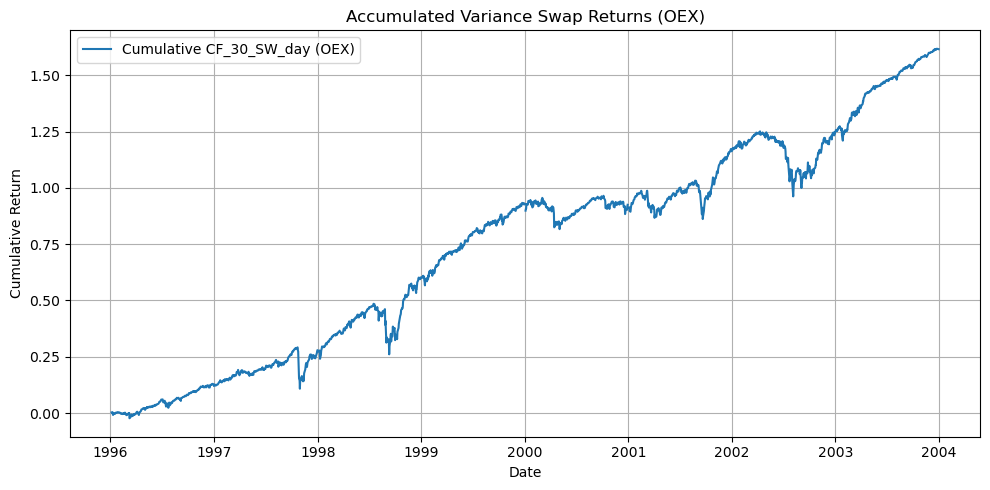

In [130]:
import matplotlib.pyplot as plt

# Filtrér for OEX
oex_df = sum_df[sum_df["ticker"] == "OEX"].copy()

# Sørg for sortering efter dato
oex_df = oex_df.sort_values("date")

# Beregn akkumuleret sum
oex_df["cum_CF_30_SW_day"] = -oex_df["CF_30_SW_day"].cumsum()

# Plot
plt.figure(figsize=(10, 5))
plt.plot(oex_df["date"], oex_df["cum_CF_30_SW_day"], label="Cumulative CF_30_SW_day (OEX)")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.title("Accumulated Variance Swap Returns (OEX)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [131]:
# Antag: sum_df har kolonnerne 'ticker', 'date', 'r_30_SW_day'
# Step 1: Fjern OEX og NA'er
vrp_data = sum_df[sum_df["ticker"] != "OEX"].copy()
vrp_data = vrp_data.dropna(subset=["r_30_SW_day"])

# Step 2: Beregn daglig VRP faktor som ligevægtet gennemsnit
vrp_factor = vrp_data.groupby("date")["r_30_SW_day"].mean().reset_index()
vrp_factor.rename(columns={"r_30_SW_day": "VRP_factor_eqw"}, inplace=True)

# Preview
print(vrp_factor.head())


        date  VRP_factor_eqw
0 1996-02-15       -0.130664
1 1996-03-06        0.025567
2 1996-03-07       -0.032031
3 1996-03-08        0.243584
4 1996-03-11       -0.028081


# Section 4.A trading strategy

### create rollnig correlation estimate

In [132]:
import pandas as pd
import numpy as np

sum_df_filtered = sum_df[sum_df['ticker'] != 'OEX'].copy()
sum_df_filtered.loc[:, 'date'] = pd.to_datetime(sum_df_filtered['date'])
pivot_df = sum_df_filtered.pivot(index='date', columns='ticker', values='return')
pivot_df = pivot_df.sort_index()

rolling_avg_corr = []
window = 30

for i in range(window, len(pivot_df)):
    window_returns = pivot_df.iloc[i - window:i]
    corr_matrix = window_returns.corr()
    upper_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    avg_corr = upper_triangle.stack().mean()
    rolling_avg_corr.append((pivot_df.index[i], avg_corr))

avg_corr_df = pd.DataFrame(rolling_avg_corr, columns=['date', 'avg_correlation'])


# import matplotlib.pyplot as plt

# plt.figure(figsize=(12, 6))
# plt.plot(avg_corr_df['date'], avg_corr_df['avg_correlation'])
# plt.title('30-dages gennemsnitlig korrelation over tid')
# plt.xlabel('Dato')
# plt.ylabel('Gennemsnitlig korrelation')
# plt.grid(True)
# plt.tight_layout()
# plt.show()



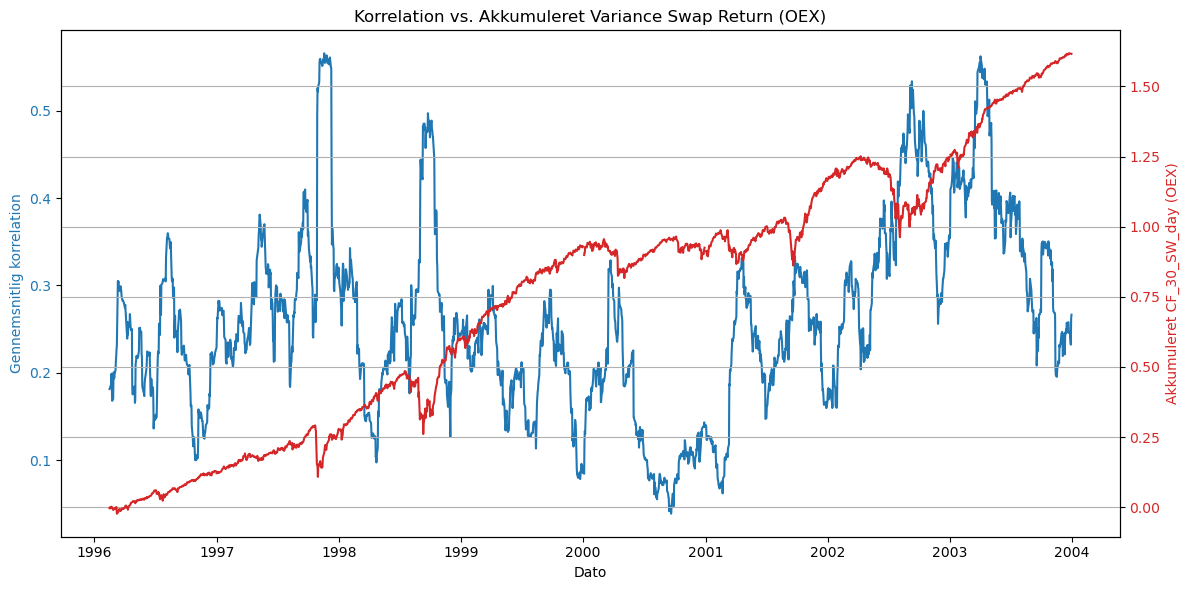

In [133]:
import matplotlib.pyplot as plt

# Filtrér for OEX og forbered data
oex_df = sum_df[sum_df["ticker"] == "OEX"].copy()
oex_df = oex_df.sort_values("date")
oex_df["cum_CF_30_SW_day"] = -oex_df["CF_30_SW_day"].cumsum()

# Merge OEX og korrelationer på dato
merged_df = pd.merge(avg_corr_df, oex_df[["date", "cum_CF_30_SW_day"]], on="date", how="inner")

# Plot med to akser
fig, ax1 = plt.subplots(figsize=(12, 6))

color = 'tab:blue'
ax1.set_xlabel("Dato")
ax1.set_ylabel("Gennemsnitlig korrelation", color=color)
ax1.plot(merged_df["date"], merged_df["avg_correlation"], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel("Akkumuleret CF_30_SW_day (OEX)", color=color)
ax2.plot(merged_df["date"], merged_df["cum_CF_30_SW_day"], color=color)
ax2.tick_params(axis='y', labelcolor=color)

plt.title("Korrelation vs. Akkumuleret Variance Swap Return (OEX)")
fig.tight_layout()
plt.grid(True)
plt.show()


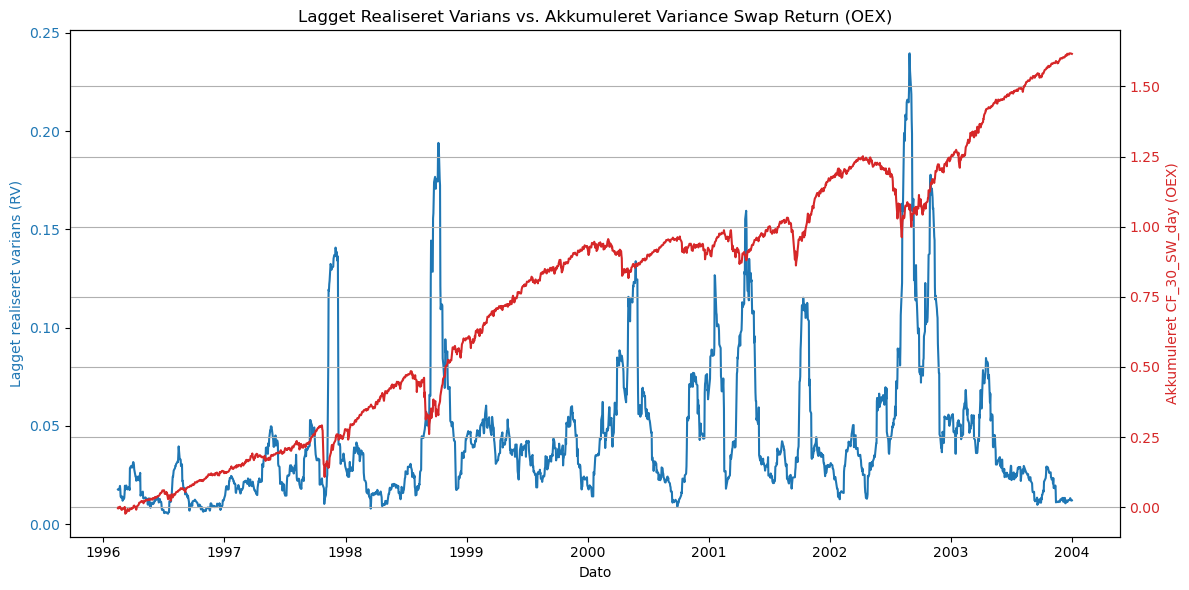

In [134]:
import matplotlib.pyplot as plt

# Filtrér for OEX og sorter
oex_df = sum_df[sum_df["ticker"] == "OEX"].copy()
oex_df = oex_df.sort_values("date")

# Lag realiseret varians 30 dage bagud
oex_df["RV_lagged"] = oex_df["RV"].shift(30)

# Beregn akkumuleret variance swap cashflow
oex_df["cum_CF_30_SW_day"] = -oex_df["CF_30_SW_day"].cumsum()

# Drop NA (som kommer fra shift)
oex_df = oex_df.dropna(subset=["RV_lagged", "cum_CF_30_SW_day"])

# Plot
fig, ax1 = plt.subplots(figsize=(12, 6))

color = 'tab:blue'
ax1.set_xlabel("Dato")
ax1.set_ylabel("Lagget realiseret varians (RV)", color=color)
ax1.plot(oex_df["date"], oex_df["RV_lagged"], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel("Akkumuleret CF_30_SW_day (OEX)", color=color)
ax2.plot(oex_df["date"], oex_df["cum_CF_30_SW_day"], color=color)
ax2.tick_params(axis='y', labelcolor=color)

plt.title("Lagget Realiseret Varians vs. Akkumuleret Variance Swap Return (OEX)")
plt.grid(True)
fig.tight_layout()
plt.show()


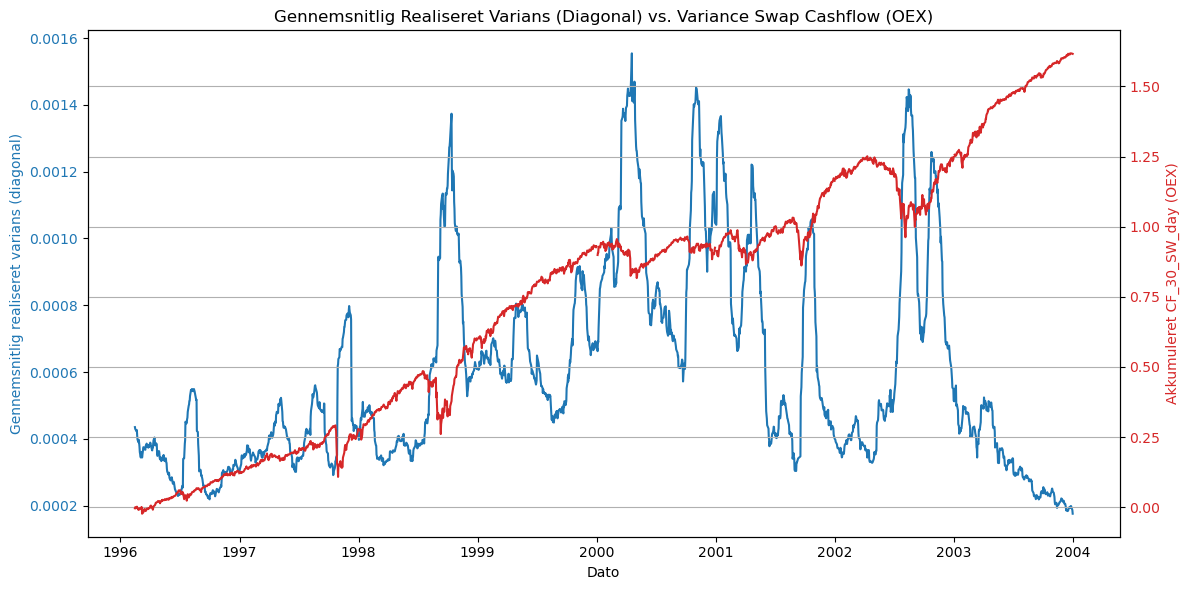

In [137]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Filtrer OEX fra
returns_df = sum_df[sum_df["ticker"] != "OEX"].copy()
returns_df['date'] = pd.to_datetime(returns_df['date'])

# Pivotér til (dato × ticker) matrix
pivot_df = returns_df.pivot(index='date', columns='ticker', values='return')
pivot_df = pivot_df.sort_index()

# Beregn rullende gennemsnitlig diagonal (varians)
window = 30
avg_diag_variance = []

for i in range(window, len(pivot_df)):
    window_returns = pivot_df.iloc[i - window:i]
    cov_matrix = window_returns.cov()
    diag_var = np.diag(cov_matrix)
    avg_var = np.nanmean(diag_var)
    avg_diag_variance.append((pivot_df.index[i], avg_var))

avg_var_df = pd.DataFrame(avg_diag_variance, columns=['date', 'avg_variance'])

# Forbered OEX cashflow
oex_df = sum_df[sum_df["ticker"] == "OEX"].copy()
oex_df = oex_df.sort_values("date")
oex_df["cum_CF_30_SW_day"] = -oex_df["CF_30_SW_day"].cumsum()

# Merge begge tidsserier
merged_df = pd.merge(avg_var_df, oex_df[["date", "cum_CF_30_SW_day"]], on="date", how="inner")

# Plot
fig, ax1 = plt.subplots(figsize=(12, 6))

color = 'tab:blue'
ax1.set_xlabel("Dato")
ax1.set_ylabel("Gennemsnitlig realiseret varians (diagonal)", color=color)
ax1.plot(merged_df["date"], merged_df["avg_variance"], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel("Akkumuleret CF_30_SW_day (OEX)", color=color)
ax2.plot(merged_df["date"], merged_df["cum_CF_30_SW_day"], color=color)
ax2.tick_params(axis='y', labelcolor=color)

plt.title("Gennemsnitlig Realiseret Varians (Diagonal) vs. Variance Swap Cashflow (OEX)")
plt.grid(True)
fig.tight_layout()
plt.show()


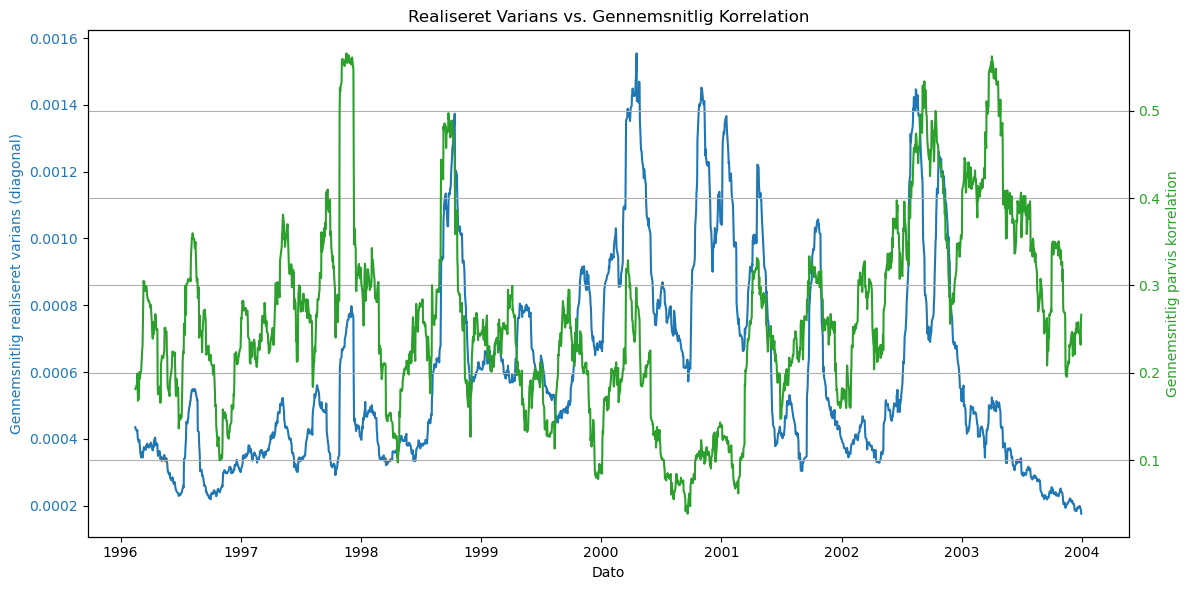

In [138]:
import matplotlib.pyplot as plt

# Merge realiseret varians og korrelation på dato
merged_metrics = pd.merge(avg_var_df, avg_corr_df, on='date', how='inner')

# Plot
fig, ax1 = plt.subplots(figsize=(12, 6))

color = 'tab:blue'
ax1.set_xlabel("Dato")
ax1.set_ylabel("Gennemsnitlig realiseret varians (diagonal)", color=color)
ax1.plot(merged_metrics["date"], merged_metrics["avg_variance"], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:green'
ax2.set_ylabel("Gennemsnitlig parvis korrelation", color=color)
ax2.plot(merged_metrics["date"], merged_metrics["avg_correlation"], color=color)
ax2.tick_params(axis='y', labelcolor=color)

plt.title("Realiseret Varians vs. Gennemsnitlig Korrelation")
plt.grid(True)
fig.tight_layout()
plt.show()


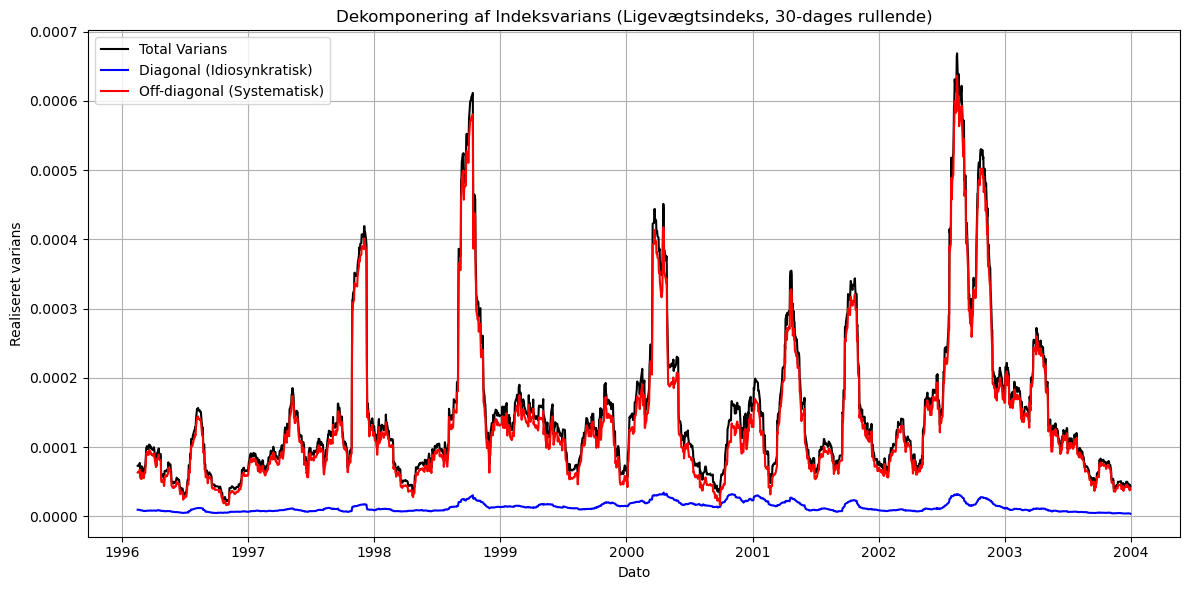

In [139]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Forbered data (ekskluder OEX)
returns_df = sum_df[sum_df["ticker"] != "OEX"].copy()
returns_df['date'] = pd.to_datetime(returns_df['date'])
pivot_df = returns_df.pivot(index='date', columns='ticker', values='return')
pivot_df = pivot_df.sort_index()

# Parametre
window = 30
decomp_data = []

# Loop over rullende vinduer
for i in range(window, len(pivot_df)):
    window_returns = pivot_df.iloc[i - window:i]
    cov_matrix = window_returns.cov()
    
    # Antal aktier i dette vindue (kan variere lidt pga. NaNs)
    tickers_in_window = cov_matrix.columns
    N = len(tickers_in_window)
    if N < 2:
        continue  # skip hvis for få data

    # Ligevægtsvægte
    w = np.ones(N) / N
    w_matrix = np.outer(w, w)

    # Total indeksvarians
    total_variance = np.sum(w_matrix * cov_matrix.values)

    # Diagonalbidrag (idiosynkratisk)
    diag = np.diag(cov_matrix.values)
    diag_variance = np.sum((w ** 2) * diag)

    # Off-diagonalbidrag
    off_diag_variance = total_variance - diag_variance

    # Gem resultat
    decomp_data.append((pivot_df.index[i], total_variance, diag_variance, off_diag_variance))

# Konverter til DataFrame
decomp_df = pd.DataFrame(decomp_data, columns=["date", "total", "diagonal", "off_diagonal"])

# Plot
plt.figure(figsize=(12, 6))
plt.plot(decomp_df["date"], decomp_df["total"], label="Total Varians", color="black")
plt.plot(decomp_df["date"], decomp_df["diagonal"], label="Diagonal (Idiosynkratisk)", color="blue")
plt.plot(decomp_df["date"], decomp_df["off_diagonal"], label="Off-diagonal (Systematisk)", color="red")
plt.title("Dekomponering af Indeksvarians (Ligevægtsindeks, 30-dages rullende)")
plt.xlabel("Dato")
plt.ylabel("Realiseret varians")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


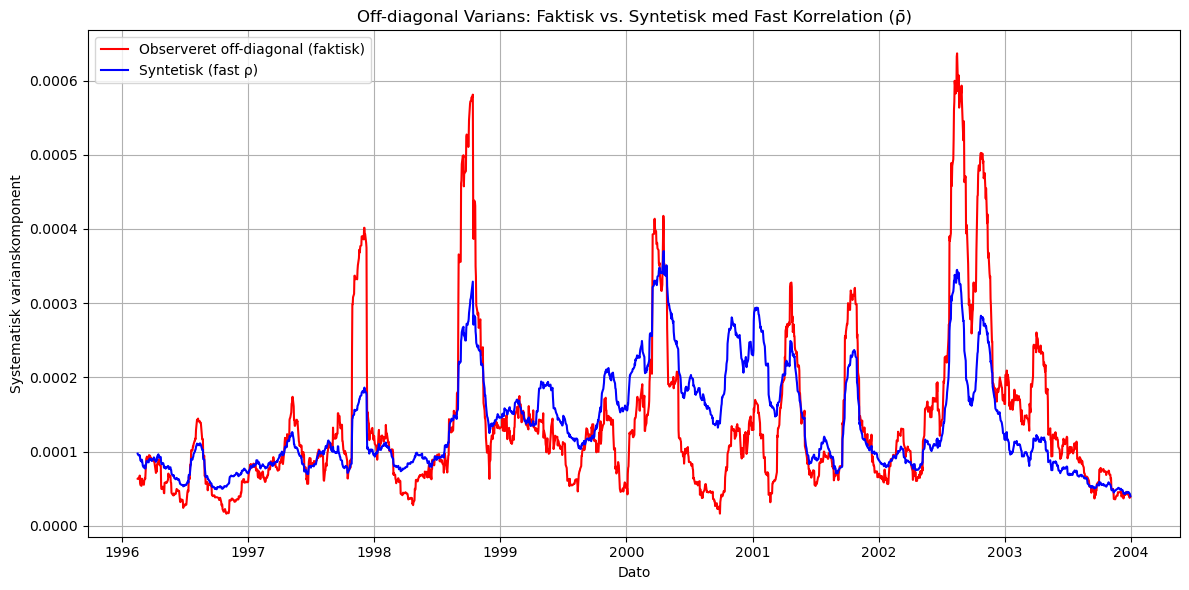

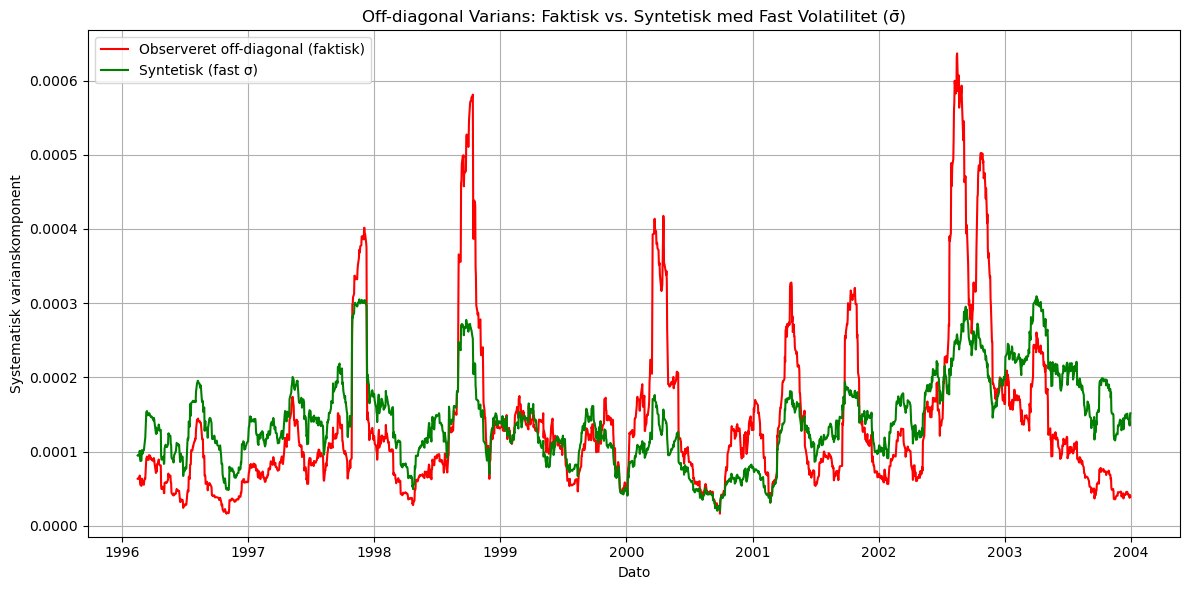

In [149]:
# Vælg om vi vil skalere syntetiske resultater
scale = False  # Sæt til True hvis du vil matche niveauer

# --------- Fast korrelation ---------
avg_rho = avg_corr_df["avg_correlation"].mean()
synthetic_off = []

for i in range(window, len(pivot_df)):
    window_returns = pivot_df.iloc[i - window:i]
    cov_matrix = window_returns.cov()

    tickers = cov_matrix.columns
    N = len(tickers)
    if N < 2:
        continue

    sigmas = np.sqrt(np.diag(cov_matrix.values))
    rho_matrix = np.full((N, N), avg_rho)
    np.fill_diagonal(rho_matrix, 0)
    sigma_outer = np.outer(sigmas, sigmas)
    synthetic_cov_off = rho_matrix * sigma_outer

    w = np.ones(N) / N
    w_matrix = np.outer(w, w)
    off_diag_mask = ~np.eye(N, dtype=bool)
    weighted_synthetic_off = synthetic_cov_off * w_matrix * off_diag_mask

    synthetic_off_value = np.sum(weighted_synthetic_off)
    synthetic_off.append((pivot_df.index[i], synthetic_off_value))

synthetic_off_df = pd.DataFrame(synthetic_off, columns=["date", "synthetic_off"])
compare_df = pd.merge(decomp_df[["date", "off_diagonal"]], synthetic_off_df, on="date", how="inner")

if scale:
    scaling_factor = (compare_df["off_diagonal"] / compare_df["synthetic_off"]).mean()
    compare_df["synthetic_plot"] = compare_df["synthetic_off"] * scaling_factor
else:
    compare_df["synthetic_plot"] = compare_df["synthetic_off"]

plt.figure(figsize=(12, 6))
plt.plot(compare_df["date"], compare_df["off_diagonal"], label="Observeret off-diagonal (faktisk)", color="red")
plt.plot(compare_df["date"], compare_df["synthetic_plot"], label="Syntetisk (fast ρ)", color="blue")
plt.title("Off-diagonal Varians: Faktisk vs. Syntetisk med Fast Korrelation (ρ̄)")
plt.xlabel("Dato")
plt.ylabel("Systematisk varianskomponent")
plt.legend(loc="upper left")
plt.grid(True)
plt.tight_layout()
plt.show()

# --------- Fast sigma ---------
long_cov = pivot_df.cov()
avg_sigmas = pd.Series(np.sqrt(np.diag(long_cov)), index=long_cov.columns)

rho_only_off = []

for i in range(window, len(pivot_df)):
    window_returns = pivot_df.iloc[i - window:i]
    corr_matrix = window_returns.corr()

    tickers = corr_matrix.columns
    N = len(tickers)
    if N < 2:
        continue

    sigmas_window = avg_sigmas.loc[tickers].values
    sigma_outer = np.outer(sigmas_window, sigmas_window)
    rho_matrix = corr_matrix.values.copy()
    np.fill_diagonal(rho_matrix, 0)

    w = np.ones(N) / N
    w_matrix = np.outer(w, w)
    off_diag_mask = ~np.eye(N, dtype=bool)
    synthetic_cov = rho_matrix * sigma_outer
    weighted_synthetic_off = synthetic_cov * w_matrix * off_diag_mask

    total_synthetic_off = np.sum(weighted_synthetic_off)
    rho_only_off.append((pivot_df.index[i], total_synthetic_off))

rho_only_df = pd.DataFrame(rho_only_off, columns=["date", "rho_only_off"])
compare_df_rho = pd.merge(decomp_df[["date", "off_diagonal"]], rho_only_df, on="date", how="inner")

if scale:
    scaling_rho = (compare_df_rho["off_diagonal"] / compare_df_rho["rho_only_off"]).mean()
    compare_df_rho["synthetic_plot"] = compare_df_rho["rho_only_off"] * scaling_rho
else:
    compare_df_rho["synthetic_plot"] = compare_df_rho["rho_only_off"]

plt.figure(figsize=(12, 6))
plt.plot(compare_df_rho["date"], compare_df_rho["off_diagonal"], label="Observeret off-diagonal (faktisk)", color="red")
plt.plot(compare_df_rho["date"], compare_df_rho["synthetic_plot"], label="Syntetisk (fast σ)", color="green")
plt.title("Off-diagonal Varians: Faktisk vs. Syntetisk med Fast Volatilitet (σ̄)")
plt.xlabel("Dato")
plt.ylabel("Systematisk varianskomponent")
plt.legend(loc="upper left")
plt.grid(True)
plt.tight_layout()
plt.show()


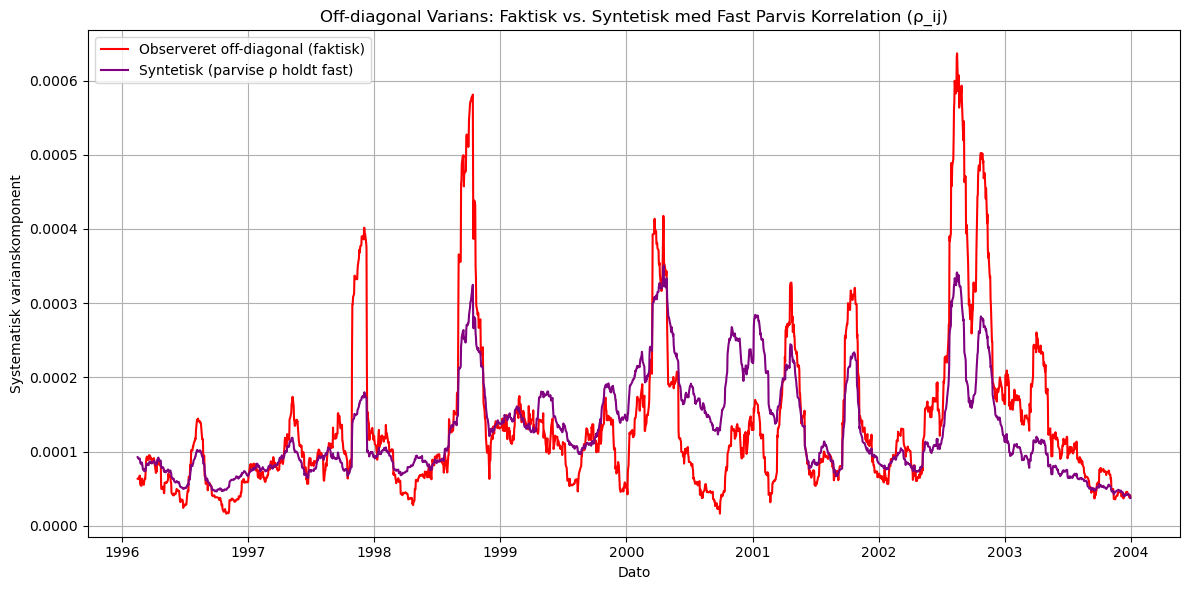

In [150]:
# Vælg om vi vil skalere syntetiske resultater
scale = False  # Sæt til True hvis du vil matche niveauer

# --------- Fast parvis korrelation (hele rho-matrix holdes fast) ---------

# Beregn gennemsnitlig korrelationsmatrix over hele perioden
full_corr = pivot_df.corr()
avg_corr_matrix = full_corr.values.copy()
np.fill_diagonal(avg_corr_matrix, 0)

synthetic_off_pairwise = []

for i in range(window, len(pivot_df)):
    window_returns = pivot_df.iloc[i - window:i]
    tickers = window_returns.columns
    N = len(tickers)
    if N < 2:
        continue

    cov_matrix = window_returns.cov()
    sigmas = np.sqrt(np.diag(cov_matrix.values))

    # Udtræk kun den relevante del af avg_corr_matrix for aktuelle tickers
    idx = [pivot_df.columns.get_loc(t) for t in tickers]
    rho_matrix = avg_corr_matrix[np.ix_(idx, idx)]

    sigma_outer = np.outer(sigmas, sigmas)
    synthetic_cov_off = rho_matrix * sigma_outer

    w = np.ones(N) / N
    w_matrix = np.outer(w, w)
    off_diag_mask = ~np.eye(N, dtype=bool)
    weighted_synthetic_off = synthetic_cov_off * w_matrix * off_diag_mask

    synthetic_value = np.sum(weighted_synthetic_off)
    synthetic_off_pairwise.append((pivot_df.index[i], synthetic_value))

synthetic_pairwise_df = pd.DataFrame(synthetic_off_pairwise, columns=["date", "synthetic_off_pairwise"])
compare_df_pairwise = pd.merge(decomp_df[["date", "off_diagonal"]], synthetic_pairwise_df, on="date", how="inner")

if scale:
    scaling_pairwise = (compare_df_pairwise["off_diagonal"] / compare_df_pairwise["synthetic_off_pairwise"]).mean()
    compare_df_pairwise["synthetic_plot"] = compare_df_pairwise["synthetic_off_pairwise"] * scaling_pairwise
else:
    compare_df_pairwise["synthetic_plot"] = compare_df_pairwise["synthetic_off_pairwise"]

plt.figure(figsize=(12, 6))
plt.plot(compare_df_pairwise["date"], compare_df_pairwise["off_diagonal"], label="Observeret off-diagonal (faktisk)", color="red")
plt.plot(compare_df_pairwise["date"], compare_df_pairwise["synthetic_plot"], label="Syntetisk (parvise ρ holdt fast)", color="purple")
plt.title("Off-diagonal Varians: Faktisk vs. Syntetisk med Fast Parvis Korrelation (ρ_ij)")
plt.xlabel("Dato")
plt.ylabel("Systematisk varianskomponent")
plt.legend(loc="upper left")
plt.grid(True)
plt.tight_layout()
plt.show()


### trading strategy implement

In [ ]:
[ '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']

# 0203524D = NSM
# NRTLQ = NT
# MTLQQ = GM
# LEHMQ = LEH
# NAN = NQN
# RSHCQ = RSH
# 987200Q = MAY
# 748957Q = PNU
# 653707Q = T
# 605555Q = S
# 3621240Q = ONE
# 3605818Q = HCA
# 3346Q = UBAN
# 2968900Q = IHRT
# 2258717D = EMC
# GBLXQ = GBLX
# ENRNQ = ENE
# EKDKQ = KODK
# DALRQ = DAL
# RTN/B = RTNB
# 1996074D = EP
# 3393199Q = BUD
# 1683997D = DELL
# 0848680D = FYBR
# 1255173D = WB
# 2071296D = NYX
# 1856613D = MON
# BRK/B = BRK
# 9903115D = CLB
# 1028411Q = G
# 1697067D = DOW
# 1715651D = DD
